<a href="https://colab.research.google.com/github/pranay8297/DDPM-DDIM-Karras/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
!pip install torch==2.1.0
!pip install datasets
# !pip install torchaudio==0.13.1
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install wandb
!pip install diffusers
!pip install tqdm
!pip install accelerate

In [ ]:
from miniai.datasets import *
from miniai.activations import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor, resize

import torch
import math
import numpy as np

from torch import nn
from torch.nn import functional as F
from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
from ipdb import set_trace as st
from functools import partial
from torch import optim
from torch.optim import lr_scheduler
import wandb

from torchvision import transforms
from torchvision.transforms import v2
from diffusers import UNet2DModel
from pathlib import Path
from tqdm import tqdm

from torch.cuda.amp import GradScaler
from torch import autocast
import time
import numpy
from accelerate import Accelerator

mdl_path = Path('drive/MyDrive/fastai_p2/models/')

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

0it [00:00, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
mpl.rcParams['image.cmap'] = 'gray'
set_seed(42)

Mounted at /content/drive


In [ ]:
dsd = load_dataset('fashion_mnist')

@inplace
def transformi(b): b['image'] = [resize(to_tensor(o), (32, 32), antialias = True) for o in b['image']]

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, 128, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify_img(self, learn.batch[0])

class UnetModel(UNet2DModel):
  def forward(self, x): return super().forward(*x).sample

class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def get_callbacks(stats_layer = GeneralRelu):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB()
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

class LossMonitoringCB(Callback):
  def __init__(self): self.losses = [4.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 2:
      print('SOME SHIT HAPPENED')
      st()
    self.losses.append(learn.loss.item())

@torch.no_grad()
def sample(model, cb = DDPMPrep(), out_shape = (16, 1, 32, 32)):
  preds, x0_coeffs, xt_coeffs = [], [], []
  n_steps, beta, alpha, alpha_bar, sigma = cb.n_steps, cb.beta.to(model.device), cb.alpha.to(model.device), cb.alpha_bar.to(model.device), cb.sigma.to(model.device)
  x_t = torch.randn(out_shape).to(model.device)
  for ts in tqdm(reversed(range(n_steps))):
    t_batch = torch.full((out_shape[0],), ts, device = model.device, dtype = torch.long)#torch.stack([torch.tensor([ts], device = model.device, dtype = torch.long)] * out_shape[0], dim = 0)
    noise_pred = model((x_t, t_batch))

    z = (torch.randn(x_t.shape) if ts > 0 else torch.zeros(x_t.shape)).to(model.device)
    alpha_bar_t_1 = alpha_bar[ts - 1] if ts > 0 else torch.tensor(1.)
    beta_bar_t = 1 - alpha_bar[ts]
    beta_bar_t_1 = 1 - alpha_bar_t_1
    alpha_bar_t = alpha_bar[ts]

    x0_hat = ((x_t - beta_bar_t.sqrt()*noise_pred)/(alpha_bar_t.sqrt())).clamp(-1, 1)
    # ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
    x0_coeff = alpha_bar_t_1.sqrt() * (1 - alpha[ts])/beta_bar_t
    xt_coeff = alpha[ts].sqrt()*beta_bar_t_1/beta_bar_t

    x_t = x0_hat*x0_coeff + xt_coeff*x_t + sigma[ts]*z

    preds.append(x_t.cpu())
    x0_coeffs.append(x0_coeff.cpu())
    xt_coeffs.append(xt_coeff.cpu())

  return preds, (x0_coeffs, xt_coeffs)

class MXLearner(TrainLearner):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.scaler = GradScaler()

  @with_cbs('batch')
  def _one_batch(self):
    self.callback('before_predict')
    self.predict()
    self.callback('after_predict')
    self.get_loss()
    self.callback('after_loss')
    if self.training:
      self.backward()
      self.callback('after_backward')
      self.step()
      self.callback('after_step')
      self.zero_grad()

  def predict(self):
    with autocast(device_type='cuda', dtype=torch.float16): super().predict()

  def get_loss(self):
    with autocast(device_type='cuda', dtype=torch.float16): super().get_loss()

  def backward(self): self.scaler.scale(self.loss).backward()

  def step(self):
    self.scaler.step(self.opt)
    self.scaler.update()

class TimerMonitoringCB(Callback):
  def __init__(self):
    self.times = []

  def before_predict(self, learn):
    self.start = time.time()

  def after_predict(self, learn):
    time_taken = (time.time() - self.start())*1000
    self.times.append()

  def after_epoch(self, learn):
    print(f'Avg time taken for a batch forward: {np.mean(self.times)}')

class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

def scaler(dist, min = 1e-04, max = 2e-02): return min + ((dist - dist.min())/(dist.max() - dist.min())) * (max - min)

def get_cosine_schedule(n_steps = 1000, min = 0.0001, max = 0.02):
  points = torch.linspace(start = math.pi, end = math.pi*2, steps = n_steps)
  dist = (torch.cos(points) + 1.)/2.
  return scaler(dist, min = min, max = max)

def get_exp(n_steps = 1000, min = 0.0001, max = 0.02, x_start = -0.5 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.exp(points), min = min, max = max)

def get_log(n_steps = 1000, min = 0.0001, max = 0.02, x_start = 0.1 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.log(points), min = min, max = max)



class DDPMPrepV2(DDPMPrep):
  def __init__(self, n_steps = 1000, beta = torch.tensor([0.]), name = 'lin'):
    fc.store_attr()
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

class AccLearnerV2(AccLearner):

  def get_sample_batch(self):
    self.batch = next(iter(self.dls.train))
    run_cbs(self.cbs, 'before_batch', self)
    return self.batch

class HackDL():
  def __init__(self, dl, mult = 2):
    self.dl = dl
    self.mult = mult

  def __len__(self):
    return len(self.dl) * self.mult

  def __iter__(self):
    d = next(iter(self.dl))
    for i in range(self.mult):
      yield d

In [ ]:
# dls = DataLoaders.from_dd(tds, 128, num_workers=2)

# Experiments in Playground

In [ ]:
x = torch.randn((4, 1, 32, 32))
n = torch.randn(x.shape)
ts = torch.randint(size = (4,), low = 0, high = 10)

beta = torch.linspace(0.1, 1, 10)
alpha = 1. - beta
alpha_bar = alpha.cumprod(0)

In [ ]:
alpha_bar.shape

torch.Size([10])

In [ ]:
ts

tensor([1, 5, 6, 4])

In [ ]:
c1 = alpha_bar[ts].sqrt()
c2 = (1. - alpha_bar[ts]).sqrt()

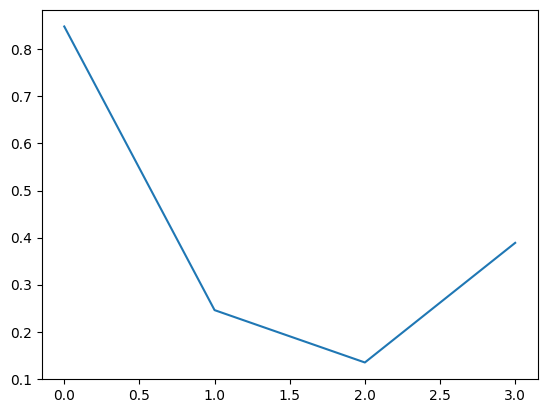

In [ ]:
plt.plot(c1)

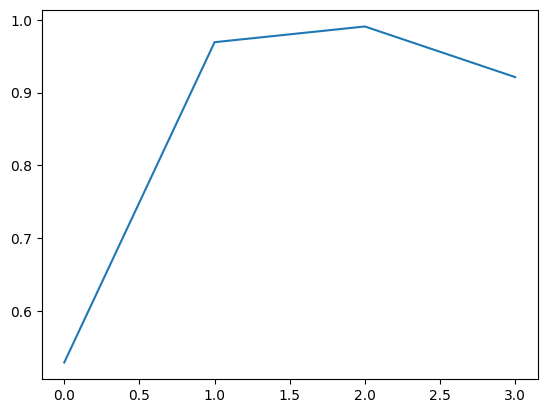

In [ ]:
plt.plot(c2)

In [ ]:
c1.shape

torch.Size([4])

In [ ]:
x.shape

torch.Size([4, 1, 32, 32])

In [ ]:
c1[:, None, None, None].shape

torch.Size([4, 1, 1, 1])

In [ ]:
c1[:, None, None, None] *

tensor([[[[0.8485]]],


        [[[0.2459]]],


        [[[0.1347]]],


        [[[0.3888]]]])

In [ ]:
x.shape

torch.Size([4, 1, 32, 32])

In [ ]:
x.mean((1, 2, 3)), x.std((1, 2, 3))

(tensor([-0.0070, -0.0118, -0.0779, -0.0054]),
 tensor([0.9981, 0.9988, 1.0180, 1.0242]))

In [ ]:
x_bar =

In [ ]:
x_bar.mean((1, 2, 3)), x_bar.std((1, 2, 3))

(tensor([-0.0060, -0.0029, -0.0105, -0.0021]),
 tensor([0.8469, 0.2456, 0.1371, 0.3983]))

In [ ]:
noise = torch.randn(x.shape)

In [ ]:
noise.mean(), noise.std()

(tensor(0.0049), tensor(0.9886))

In [ ]:
noise[2].mean(), noise[2].std()

(tensor(-0.0003), tensor(1.0068))

In [ ]:
x_bar = c1[:, None, None, None] * x + c2[:, None, None, None] * noise

In [ ]:
x_bar.shape

torch.Size([4, 1, 32, 32])

In [ ]:
x_bar.mean((1, 2, 3)), x_bar.std((1, 2, 3))

(tensor([ 0.0040,  0.0121, -0.0107, -0.0156]),
 tensor([0.9898, 0.9885, 1.0087, 1.0106]))

In [ ]:
x, y = next(iter(dls.train))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

In [ ]:
x.shape

torch.Size([128, 1, 32, 32])

In [ ]:
x = x[2]

<Axes: >

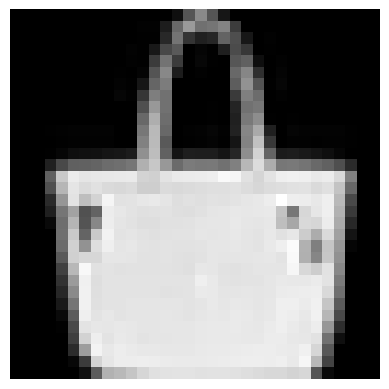

In [ ]:
show_image(x)

In [ ]:
xs = torch.cat([x]*16, dim = 0)[:, None, :, :]

In [ ]:
xs.shape

torch.Size([16, 1, 32, 32])

In [ ]:
n = torch.randn(xs.shape)
ts = torch.randint(size = (16,), low = 0, high = 1000)

beta = torch.linspace(0.0001, 0.02, 1000)
alpha = 1. - beta
alpha_bar = alpha.cumprod(0)

In [ ]:
ts

tensor([805, 790, 521, 822, 628, 780, 364, 464,  56,  91,  14, 303, 321, 736,
        244, 873])

In [ ]:
c1 = alpha_bar[ts].sqrt()
c2 = (1. - alpha_bar[ts]).sqrt()

In [ ]:
x_bar = c1[:, None, None, None] * xs + c2[:, None, None, None] * n

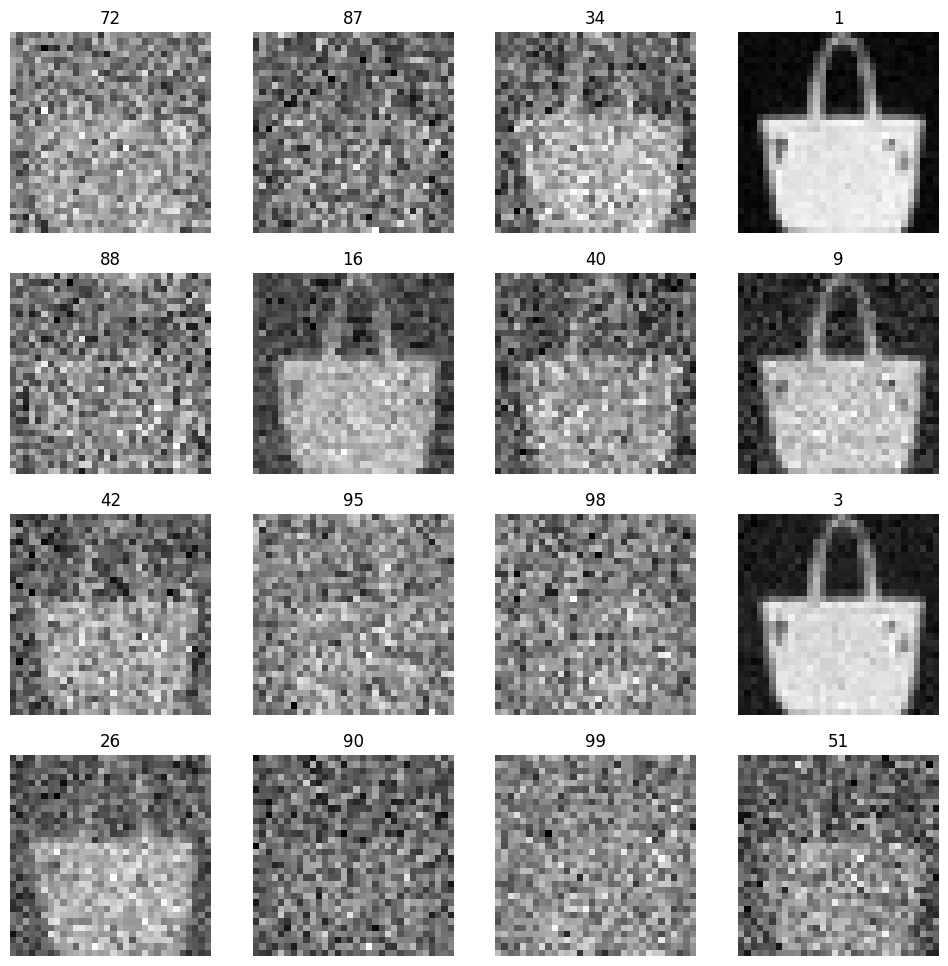

In [ ]:
show_images(x_bar, titles = [str(int(i)) for i in ts])

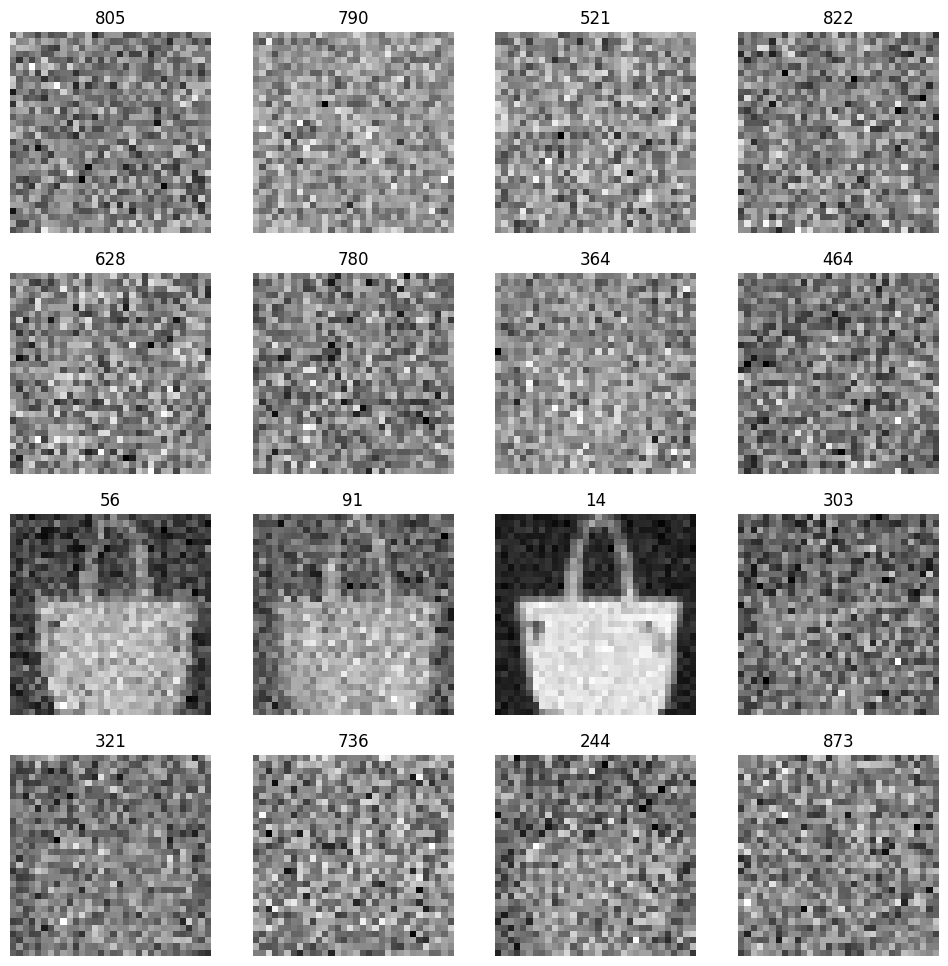

In [ ]:
show_images(x_bar, titles = [str(int(i)) for i in ts])

# Training

In [ ]:
def noisify_img(cb_obj, x_0):
  n = x_0.shape[0]
  device = x_0.device
  noise = torch.randn(x_0.shape, device = device)
  ts = torch.randint(0, cb_obj.n_steps, size = (n,), device = device, dtype = torch.long)

  if cb_obj.alpha_bar.device != device: cb_obj.alpha_bar = cb_obj.alpha_bar.to(device)

  c1 = cb_obj.alpha_bar[ts].sqrt()[:, None, None, None].to(device)
  c2 = (1 - cb_obj.alpha_bar[ts]).sqrt()[:, None, None, None].to(device)
  x_t = c1*x_0 + c2*noise

  return (x_t, ts), noise

In [ ]:
class DDPMPrep(Callback):
  def __init__(self, n_steps = 1000, beta_min = 0.0001, beta_max = 0.02):
    fc.store_attr()
    self.beta = torch.linspace(beta_min, beta_max, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify_img(self, learn.batch[0])

In [ ]:
class UnetModel(UNet2DModel):
  def forward(self, x): return super().forward(*x).sample

In [ ]:
class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

def get_callbacks(stats_layer = GeneralRelu):
  astats = ActivationStats(fc.risinstance(stats_layer))
  metrics = MetricsCB()
  return [DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), metrics, ProgressCB(plot = True), astats]

In [ ]:
class LossMonitoringCB(Callback):
  def __init__(self): self.losses = [4.0]
  def after_loss(self, learn):
    if not learn.training: return
    if learn.loss.item() > self.losses[-1] * 2:
      print('SOME SHIT HAPPENED')
      st()
    self.losses.append(learn.loss.item())


In [ ]:
model = UnetModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))
lr_max, epochs = 5e-03, 5
cbs = get_callbacks(nn.BatchNorm2d) + [
          DDPMPrep(),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          LossMonitoringCB()
      ]
learner = TrainLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = torch.optim.Adam)
learner.fit(epochs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/fastai_p2/models/

fashion_ddpm.pkl


In [ ]:
from pathlib import Path
mdl_path = Path('drive/MyDrive/fastai_p2/models/')
mdl_path.mkdir(exist_ok=True)
# Save the model
torch.save(learner.model, mdl_path/'fashion_ddpm.pkl')

# Inference

In [ ]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample

    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise
        learn.batch = ((xt, t), ε)

    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds, x0_coeffs, xt_coeffs = [], [], []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learner.model((x_t, t_batch))
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
            x0_coeffs.append(x0_coeff.cpu())
            xt_coeffs.append(xt_coeff.cpu())
        return preds, x0_coeffs, xt_coeffs

In [ ]:
model = UnetModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))
lr_max, epochs = 1e-03, 5
ddpm_cb = DDPMCB(1000, 0.0001, 0.002)
cbs = get_callbacks(nn.BatchNorm2d) + [
          ddpm_cb,
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          LossMonitoringCB()
      ]
learner = TrainLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = torch.optim.Adam)
# learner.model = torch.load(mdl_path/'fashion_ddpm.pkl')

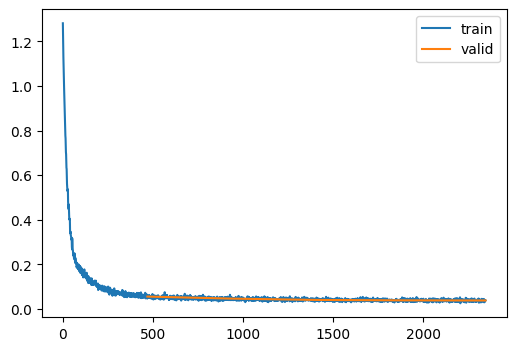

In [ ]:
# Trying to replicate whats been happening in Tanishks notebook.
learner.fit(epochs)

In [ ]:
torch.save(learner.model, mdl_path/'fashion_ddpm_v2.pkl')

In [ ]:
learner.model = torch.load(mdl_path/'fashion_ddpm_v2.pkl')

In [ ]:
samples, x0_c, xt_c = ddpm_cb.sample(learner.model, (16, 1, 32, 32))

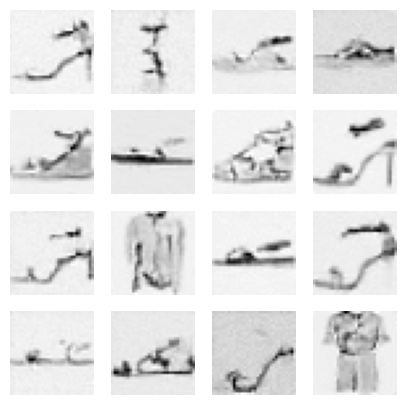

In [ ]:
show_images(-samples[-1], figsize=(5,5))

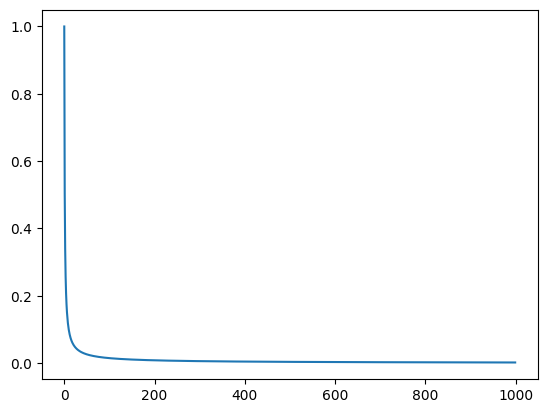

In [ ]:
plt.plot(list(reversed(x0_c)))

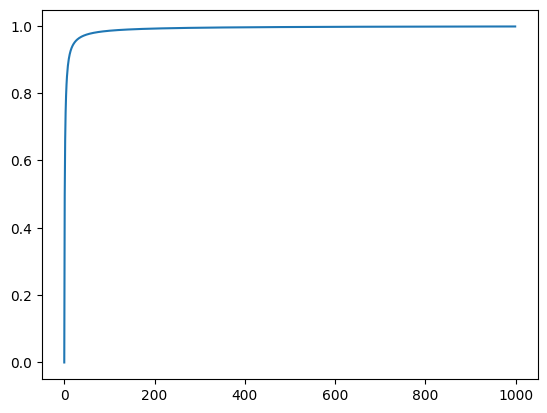

In [ ]:
plt.plot(list(reversed(xt_c)))

# Plotting for better understanding.

In [ ]:
fracs = []
for i in range(len(cbs[-3].beta) - 1):
  fracs.append(cbs[-3].beta[i]/cbs[-3].beta[i+1])

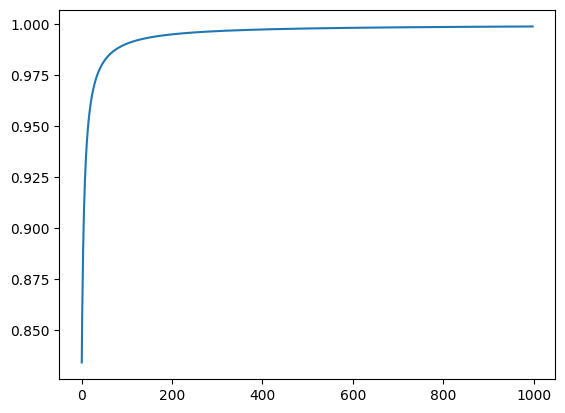

In [ ]:
plt.plot(fracs)

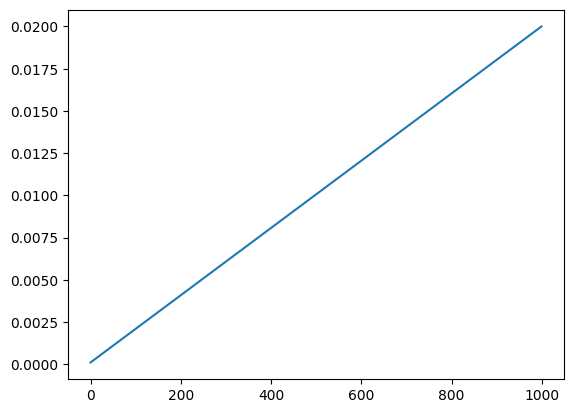

In [ ]:
plt.plot(cbs[-3].beta)

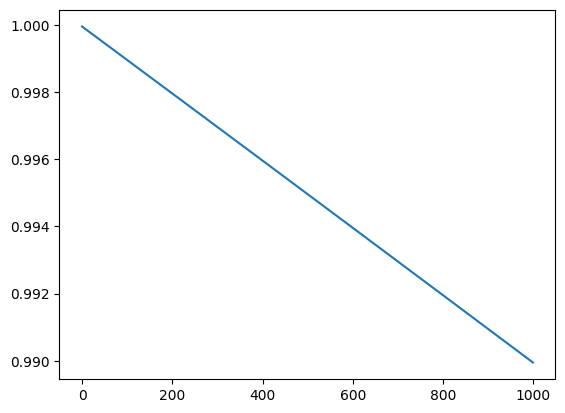

In [ ]:
plt.plot(cbs[-3].alpha.sqrt())

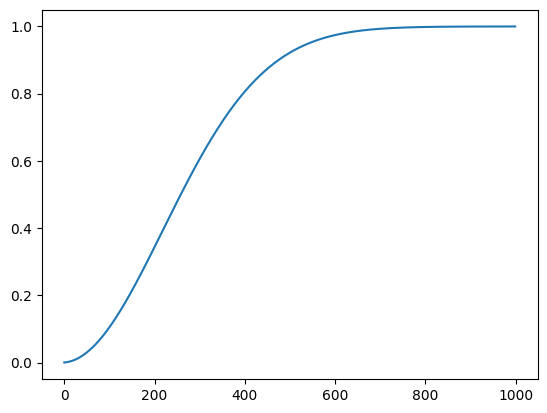

In [ ]:
plt.plot((1 - cbs[-3].alpha_bar))

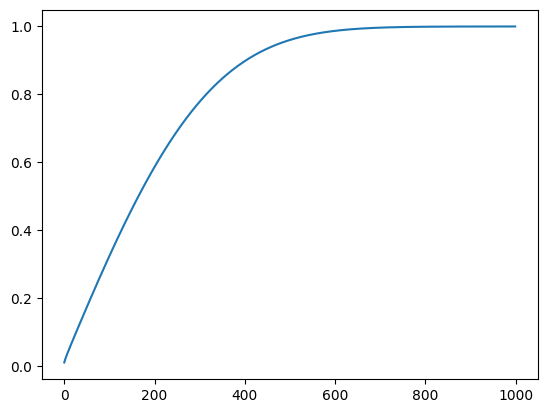

In [ ]:
plt.plot((1 - cbs[-3].alpha_bar).sqrt())

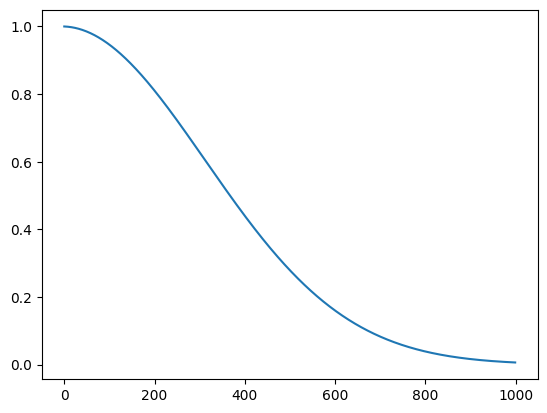

In [ ]:
plt.plot(cbs[-3].alpha_bar.sqrt())

In [ ]:
o = cbs[-3]
dist = []
for i in range(1, len(o.alpha_bar)):
  dist.append(o.alpha_bar[i - 1].sqrt()*o.beta[i]/(1 - o.alpha_bar[i]))


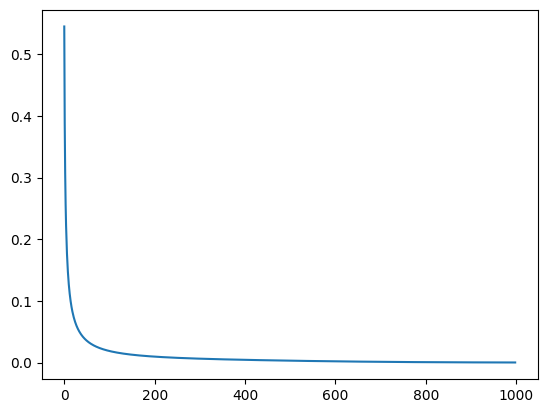

In [ ]:
plt.plot(dist)

# Error Fixing in Generating Sample code


In [ ]:
learner.model.device

device(type='cuda', index=0)

In [ ]:
x_t = torch.randn((1, 32, 32)).to(model.device)
x_t[None, :].shape

torch.Size([1, 1, 32, 32])

In [ ]:
!pip install tqdm
from tqdm import tqdm

In [ ]:
@torch.no_grad()
def sample(model = learner.model, cb = DDPMPrep(), out_shape = (16, 1, 32, 32)):
  preds, x0_coeffs, xt_coeffs = [], [], []
  n_steps, beta, alpha, alpha_bar, sigma = cb.n_steps, cb.beta.to(model.device), cb.alpha.to(model.device), cb.alpha_bar.to(model.device), cb.sigma.to(model.device)
  x_t = torch.randn(out_shape).to(model.device)
  for ts in tqdm(reversed(range(n_steps))):
    t_batch = torch.full((out_shape[0],), ts, device = model.device, dtype = torch.long)#torch.stack([torch.tensor([ts], device = model.device, dtype = torch.long)] * out_shape[0], dim = 0)
    noise_pred = model((x_t, t_batch))

    z = (torch.randn(x_t.shape) if ts > 0 else torch.zeros(x_t.shape)).to(model.device)
    alpha_bar_t_1 = alpha_bar[ts - 1] if ts > 0 else torch.tensor(1.)
    beta_bar_t = 1 - alpha_bar[ts]
    beta_bar_t_1 = 1 - alpha_bar_t_1
    alpha_bar_t = alpha_bar[ts]

    x0_hat = ((x_t - beta_bar_t.sqrt()*noise_pred)/(alpha_bar_t.sqrt())).clamp(-1, 1)
    # ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
    x0_coeff = alpha_bar_t_1.sqrt() * (1 - alpha[ts])/beta_bar_t
    xt_coeff = alpha[ts].sqrt()*beta_bar_t_1/beta_bar_t

    x_t = x0_hat*x0_coeff + xt_coeff*x_t + sigma[ts]*z

    preds.append(x_t.cpu())
    x0_coeffs.append(x0_coeff.cpu())
    xt_coeffs.append(xt_coeff.cpu())

  return preds, x0_coeffs, xt_coeffs



In [ ]:
torch.full((16,), 23)

tensor([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23])

In [ ]:
learner.model = torch.load(mdl_path/'fashion_ddpm.pkl')
out = sample(model = learner.model)

1000it [00:30, 33.14it/s]


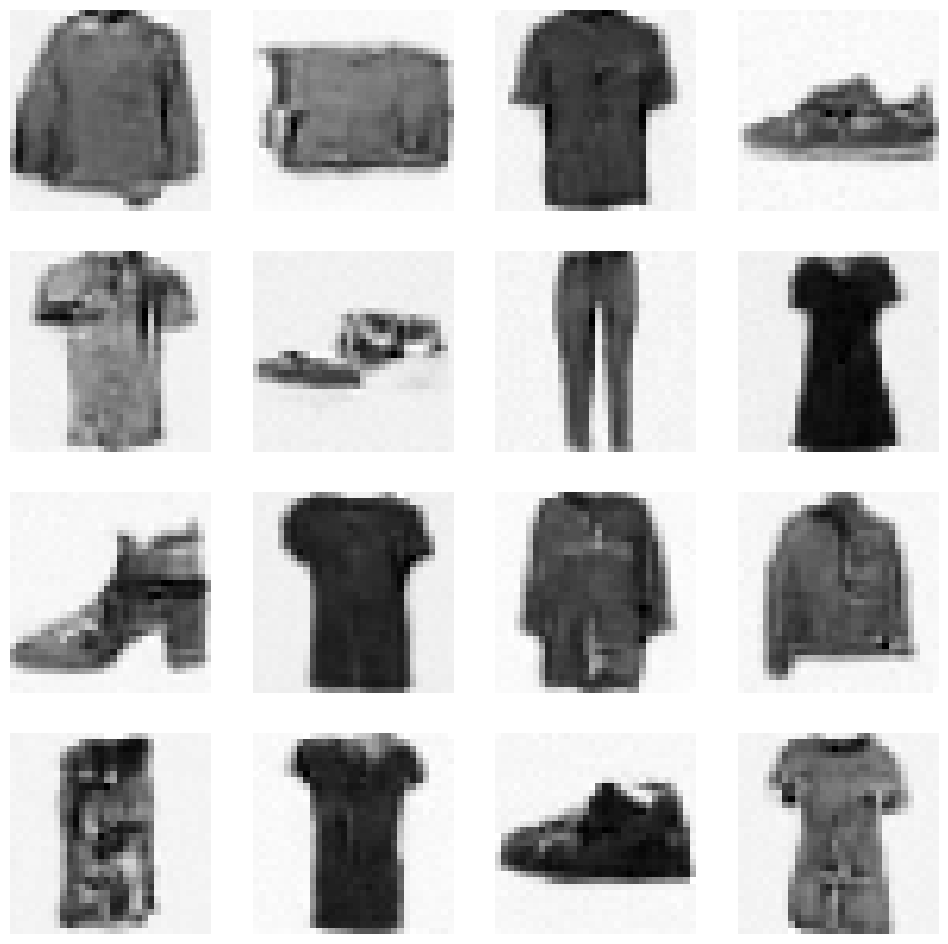

In [ ]:
show_images(-out[0][-1])

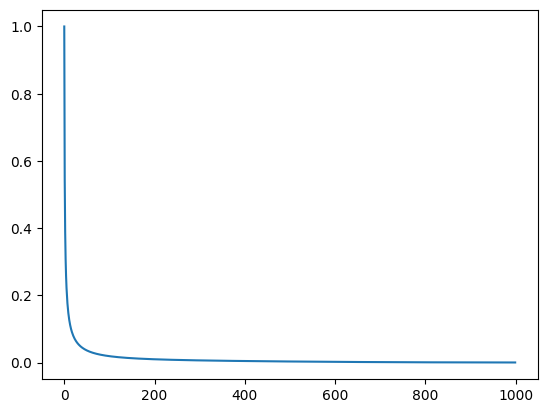

In [ ]:
plt.plot(list(reversed(out[1])))

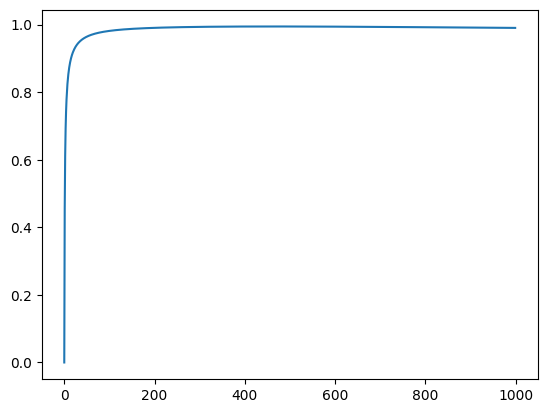

In [ ]:
plt.plot(list(reversed(out[2])))

In [ ]:
samples = out[0]

In [ ]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML
from fastcore.foundation import L

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(10,990, 2)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))


Using matplotlib backend: agg


# Lets try out other variant!

In [ ]:
# lets try training the model with Adam with eps of 1e-05 instead of default 1e-08 - Check is this the reason why the loss is spiking.
# Lets use our own unet that we built for fashion mnist reconstruction. and use it for this training.
# Replace the normal conv blocks with res blocks.
# Try out mixed precision - Start the video here - Done
# Try new noise schedules - Like cosine schedule for beta (from pi to 2*pi) - scale it from 0.0001 to 0.002
# Other schedules like - e^x - e^0
# Try Reduce the timesteps!

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (16, 32, 64, 64))
lr_max, epochs = 5e-03, 4
cbs = get_callbacks(nn.BatchNorm2d) + [
          DDPMPrep(),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          LossMonitoringCB()
      ]
learner = TrainLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
learner.fit(epochs)

In [ ]:
torch.save(learner.model, mdl_path/'fashion_ddpm_v3.pkl')

In [ ]:
out, _ = sample(learner.model)

1000it [00:34, 29.13it/s]


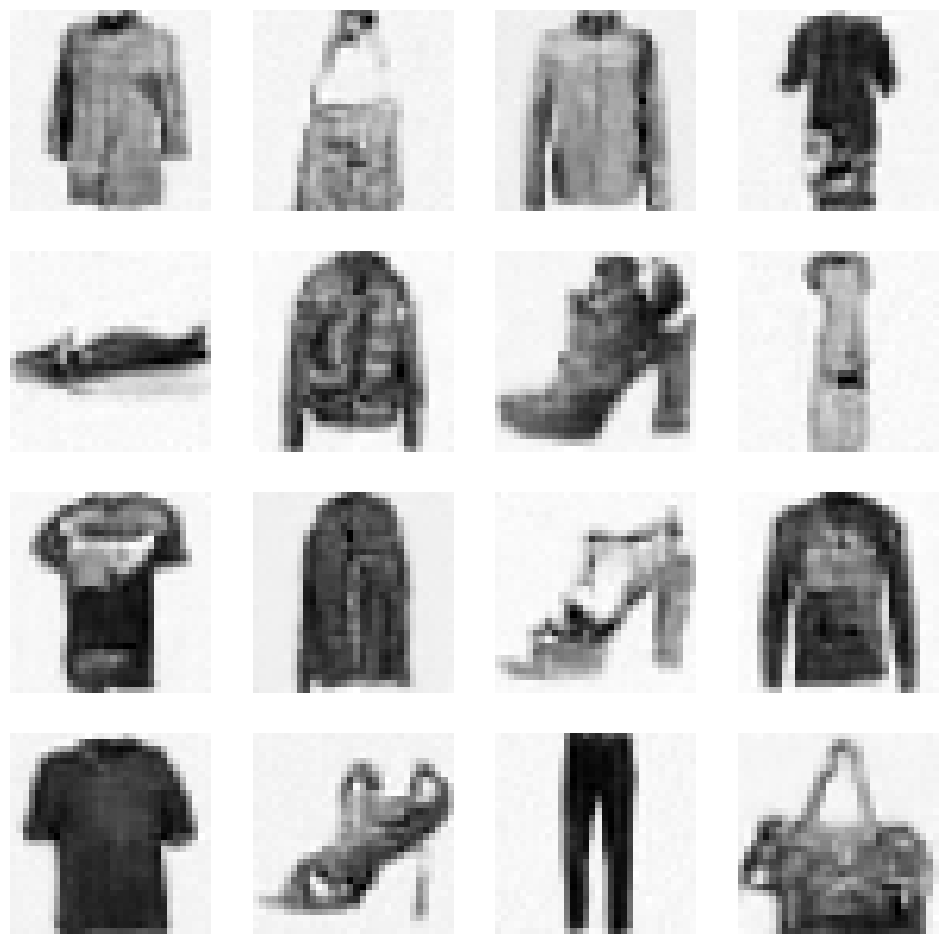

In [ ]:
show_images(-out[-1])

In [ ]:
# Mixed Precision
# Lets implement Mixed Precision

In [ ]:
# Test
model = Net().cuda()
optimizer = optim.SGD(model.parameters(), ...)

# Creates a GradScaler once at the beginning of training.
scaler = GradScaler()

for epoch in epochs:
    for input, target in data:
        optimizer.zero_grad()

        # Runs the forward pass with autocasting.
        with autocast(device_type='cuda', dtype=torch.float16):
            output = model(input)
            loss = loss_fn(output, target)

        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()


In [ ]:
from torch.cuda.amp import GradScaler
from torch import autocast

class MXLearner(TrainLearner):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.scaler = GradScaler()

  @with_cbs('batch')
  def _one_batch(self):
    self.callback('before_predict')
    self.predict()
    self.callback('after_predict')
    self.get_loss()
    self.callback('after_loss')
    if self.training:
      self.backward()
      self.callback('after_backward')
      self.step()
      self.callback('after_step')
      self.zero_grad()

  def predict(self):
    with autocast(device_type='cuda', dtype=torch.float16): super().predict()

  def get_loss(self):
    with autocast(device_type='cuda', dtype=torch.float16): super().get_loss()

  def backward(self): self.scaler.scale(self.loss).backward()

  def step(self):
    self.scaler.step(self.opt)
    self.scaler.update()

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 5e-03, 5
dls = DataLoaders.from_dd(tds, 512, num_workers=2)
cbs = get_callbacks(nn.BatchNorm2d) + [
          DDPMPrep(),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          # LossMonitoringCB()
          # TimerMonitoringCB()
      ]
mx_learn = MXLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))

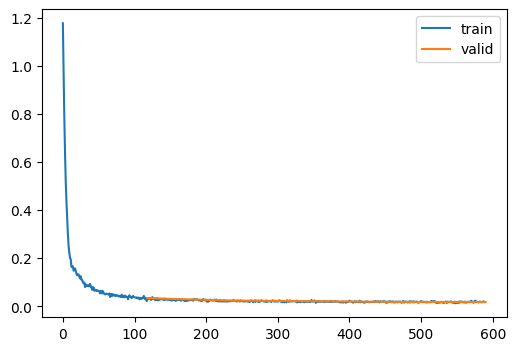

In [ ]:
mx_learn.fit(epochs)

In [ ]:
class TimerMonitoringCB(Callback):
  def __init__(self):
    self.times = []

  def before_predict(self, learn):
    self.start = time.time()

  def after_predict(self, learn):
    time_taken = (time.time() - self.start())*1000
    self.times.append()

  def after_epoch(self, learn):
    print(f'Avg time taken for a batch forward: {np.mean(self.times)}')

In [ ]:
mx_learn = None
learner = None
import gc
gc.collect()

19956

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
torch.save(mx_learn.model.state_dict(), mdl_path/'fashion_ddpm_mxp.pkl')

In [ ]:
out, _ = sample(mx_learn.model)

1000it [00:30, 32.81it/s]


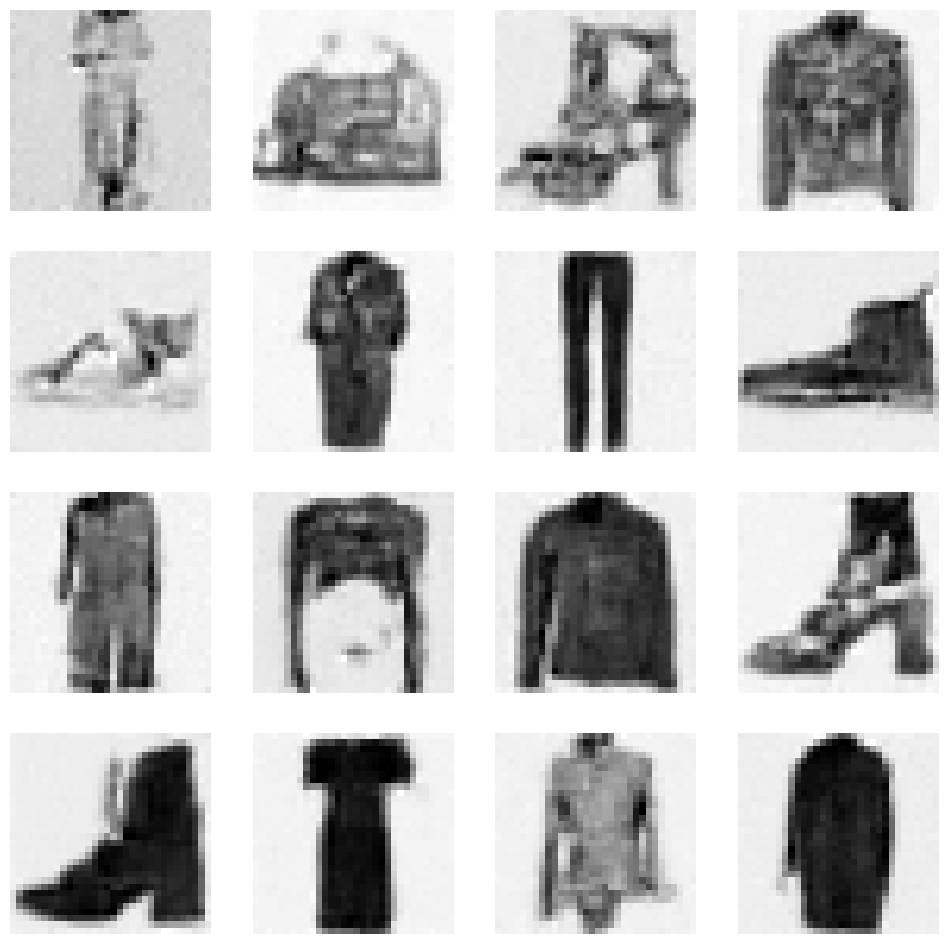

In [ ]:
show_images(-out[-1])

In [ ]:
mx_learn.model = torch.load(mdl_path/'fashion_ddpm_mxp.pkl')

In [ ]:
mx_learn = None
del mx_learn
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from accelerate import Accelerator

In [ ]:
class AccLearner(TrainLearner):

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.aclr = Accelerator()
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.model, self.opt, self.dls.train, self.dls.valid = self.aclr.prepare(self.model, self.opt, self.dls.train, self.dls.valid)

  def backward(self): self.aclr.backward(self.loss)

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8
dls = DataLoaders.from_dd(tds, 512, num_workers=2)
cbs = get_callbacks(nn.BatchNorm2d) + [
          DDPMPrep(),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
          # LossMonitoringCB()
          # TimerMonitoringCB()
      ]
mx_learn = AccLearner(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))

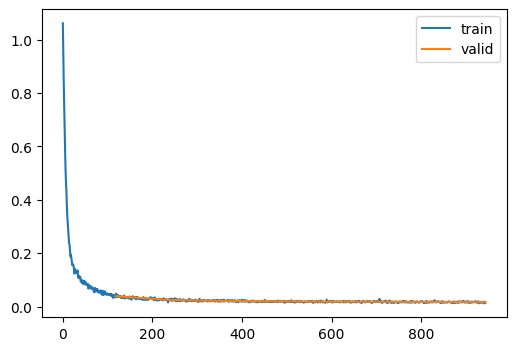

In [ ]:
mx_learn.fit(epochs)

1000it [00:32, 30.56it/s]


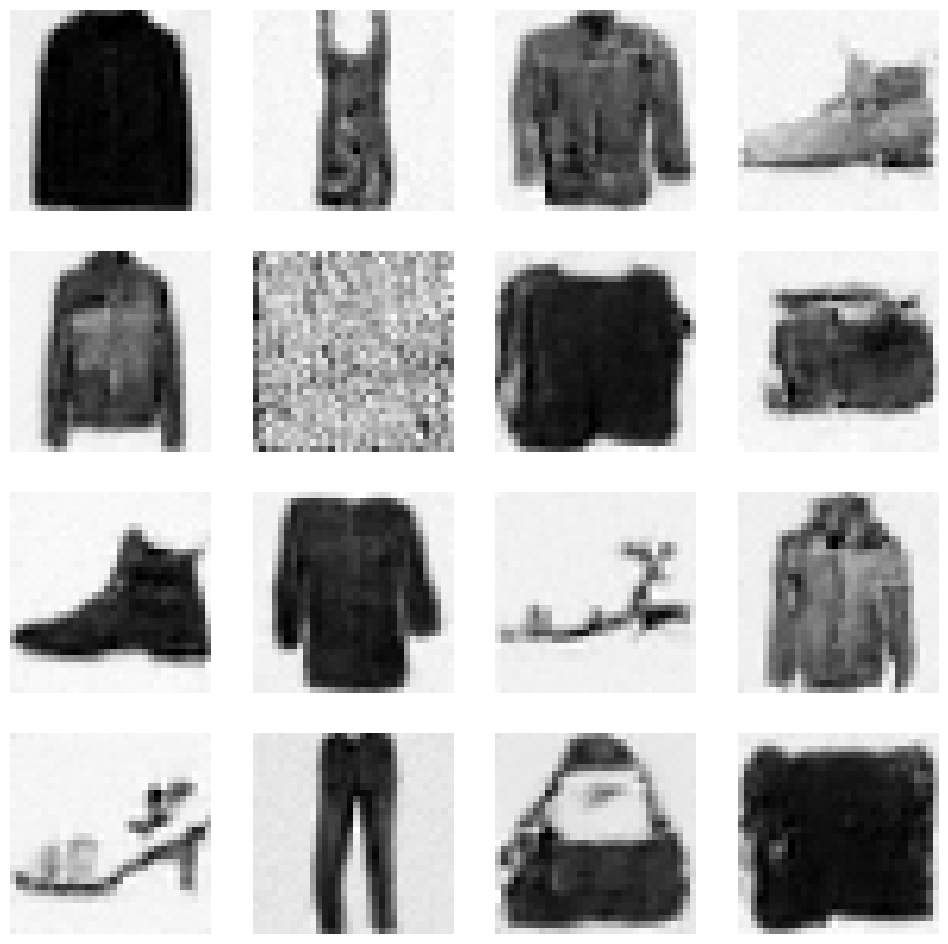

In [ ]:
out, _ = sample(mx_learn.model)
show_images(-out[-1])

In [ ]:
torch.save(mx_learn.model.state_dict(), mdl_path/'fashion_ddpm_mxp_v2.pkl')

# Checking out different Beta Schedules (cos, exp, log)

In [ ]:
def get_cosine_schedule(n_steps = 1000, min = 0.0001, max = 0.02):
  points = torch.linspace(start = math.pi, end = math.pi*2, steps = n_steps)
  dist = (torch.cos(points) + 1.)/2.
  return scaler(dist, min = min, max = max)

def get_exp(n_steps = 1000, min = 0.0001, max = 0.02, x_start = -0.5 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.exp(points), min = min, max = max)

def get_log(n_steps = 1000, min = 0.0001, max = 0.02, x_start = 0.1 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.log(points), min = min, max = max)

def scaler(dist, min = 1e-04, max = 2e-02): return min + ((dist - dist.min())/(dist.max() - dist.min())) * (max - min)

class DDPMPrepV2(DDPMPrep):
  def __init__(self, n_steps = 1000, beta = torch.tensor([0.]), name = 'lin'):
    fc.store_attr()
    self.alpha = 1. - self.beta
    self.alpha_bar = self.alpha.cumprod(0)
    self.sigma = self.beta.sqrt()

In [ ]:
cos_cb = DDPMPrepV2(n_steps = 1000, beta = get_cosine_schedule(), name = 'cos')
exp_cb = DDPMPrepV2(n_steps = 1000, beta = get_exp(), name = 'exp')
log_cb = DDPMPrepV2(n_steps = 1000, beta = get_log(), name = 'log')
cb = DDPMPrep()

In [ ]:
cbs = [cos_cb, exp_cb, log_cb, cb]

In [ ]:
def plot_attrs(cbs = [], name = 'alpha_bar', func = fc.noop):
  for i in cbs:
    plt.plot(func(getattr(i, name)), label = getattr(i, "name", 'basic'))
  plt.legend()

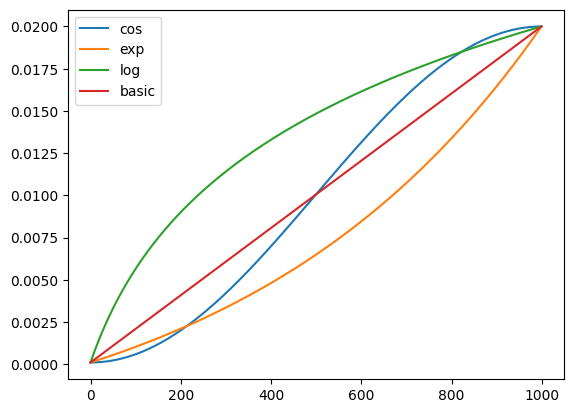

In [ ]:
plot_attrs('beta')

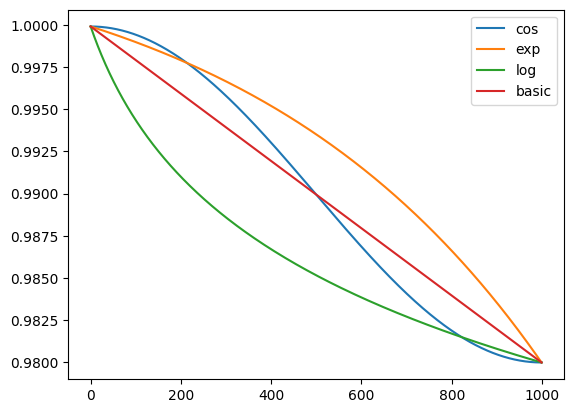

In [ ]:
plot_attrs('alpha' )

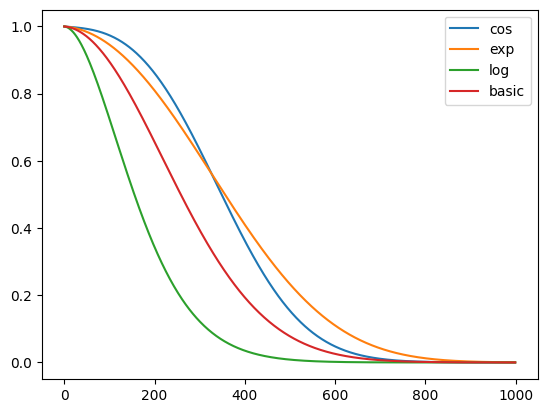

In [ ]:
plot_attrs('alpha_bar')

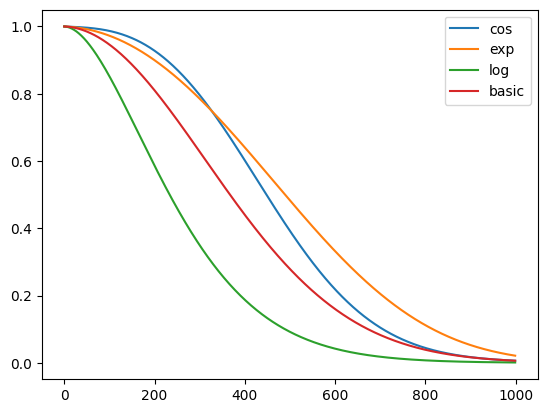

In [ ]:
plot_attrs('alpha_bar', func = torch.sqrt)

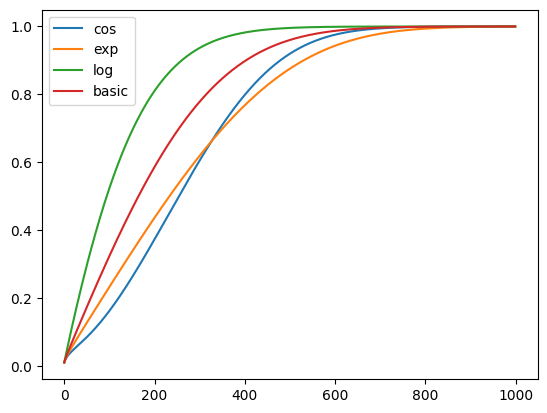

In [ ]:
def c2_func(dist): return torch.sqrt((1. - dist))
plot_attrs('alpha_bar', func = c2_func)

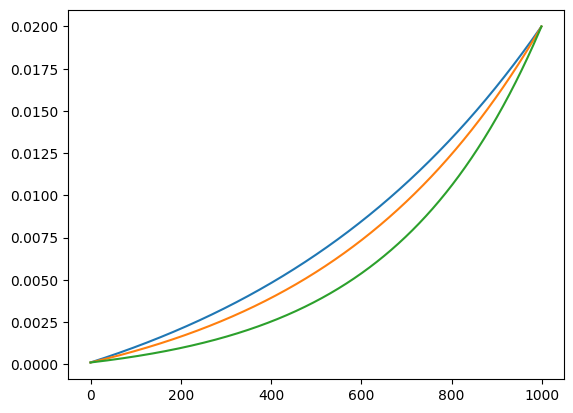

In [ ]:
import matplotlib as mpl, matplotlib.pyplot as plt
import torch

def scaler(dist, min = 1e-04, max = 2e-02): return min + ((dist - dist.min())/(dist.max() - dist.min())) * (max - min)

def get_cosine_schedule(n_steps = 1000, min = 0.0001, max = 0.02):
  points = torch.linspace(start = math.pi, end = math.pi*2, steps = n_steps)
  dist = (torch.cos(points) + 1.)/2.
  return scaler(dist, min = min, max = max)

def get_exp(n_steps = 1000, min = 0.0001, max = 0.02, x_start = -0.5 , x_end = 1.):
  points = torch.linspace(start = x_start , end = x_end , steps = n_steps)
  return scaler(torch.exp(points), min = min, max = max)

plt.plot(get_exp())
plt.plot(get_exp(x_start = -1, x_end = 1))
plt.plot(get_exp(x_start = -2, x_end = 1))

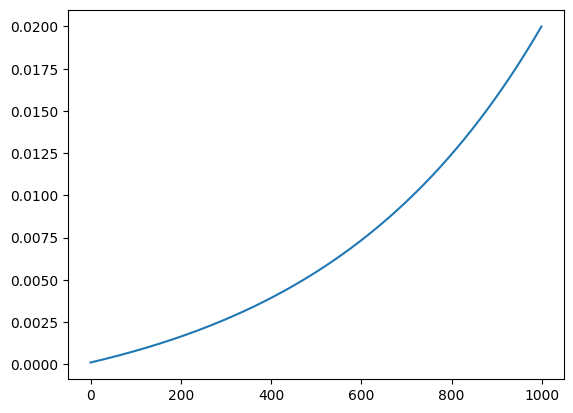

# Trying out Cosine Schedule for Beta

In [ ]:
class AccLearnerV2(AccLearner):

  def get_sample_batch(self):
    self.batch = next(iter(self.dls.train))
    run_cbs(self.cbs, 'before_batch', self)
    return self.batch

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8
dls = DataLoaders.from_dd(tds, 512, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_cosine_schedule()),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]
learner = AccLearnerV2(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))

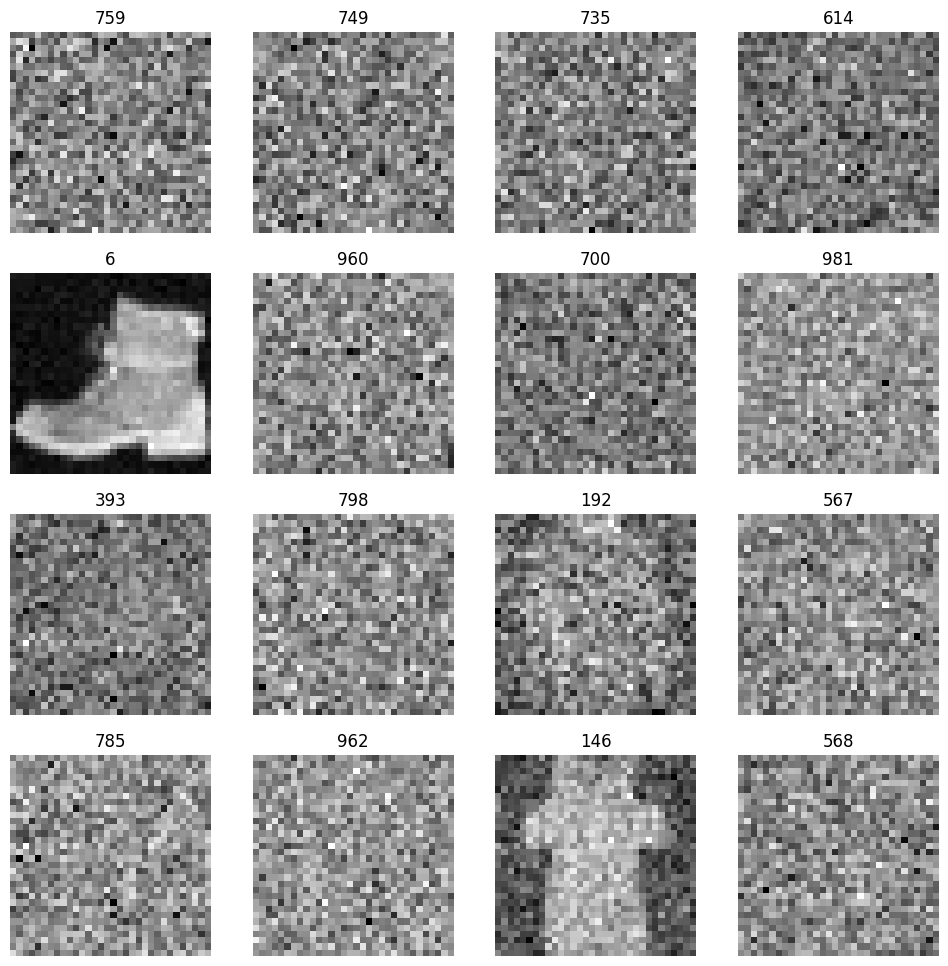

In [ ]:
# show_images(out[0][0][:16].cpu(), titles = out[0][1][:16].cpu())
out = learner.get_sample_batch()
show_images(out[0][0][:16].cpu(), titles = list(out[0][1][:16].cpu().numpy()))

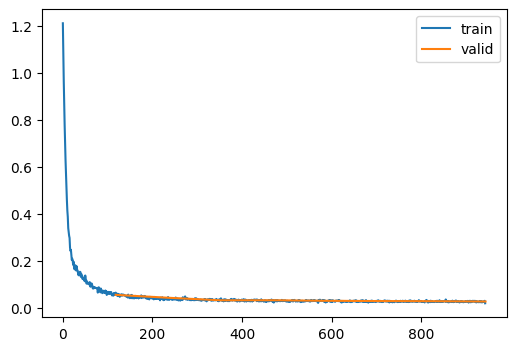

In [ ]:
learner.fit(epochs)

In [ ]:
class HackDL():
  def __init__(self, dl, mult = 2):
    self.dl = dl
    self.mult = mult
  def __iter__(self):
    d = next(iter(self.dl))
    for i in range(self.mult):
      yield d

In [ ]:
out, coeffs = sample(learner.model, cb = cbs[-2])

1000it [00:33, 29.43it/s]


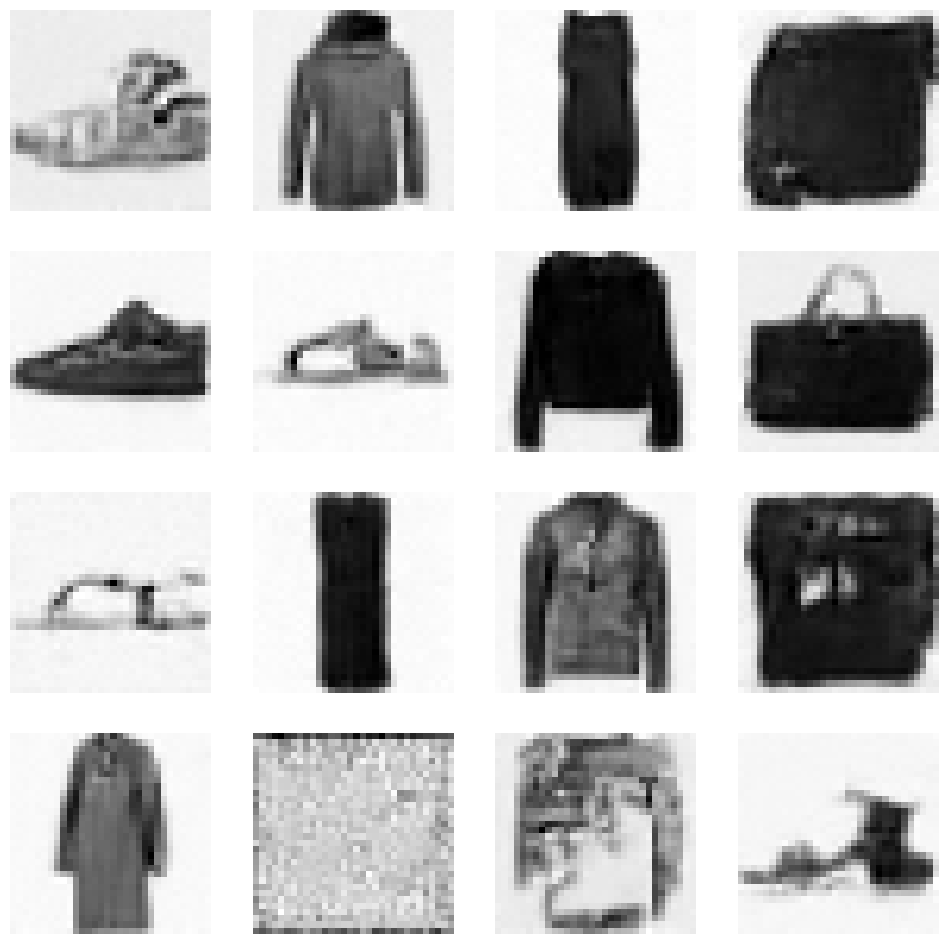

In [ ]:
show_images(-out[-1])

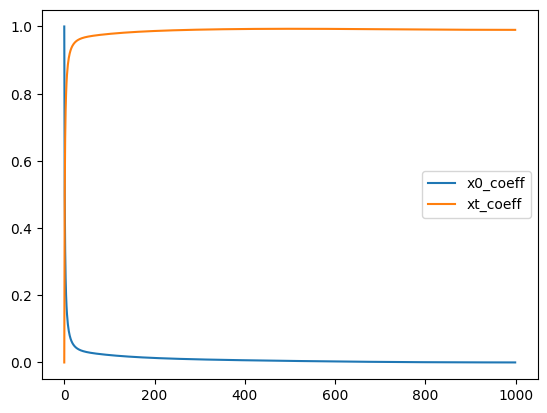

In [ ]:
plt.plot(list(reversed(coeffs[0])), label = 'x0_coeff')
plt.plot(list(reversed(coeffs[1])), label = 'xt_coeff')
plt.legend()

# Exp Beta Scheduler (e^x)

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 8
dls = DataLoaders.from_dd(tds, 512, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 1000, beta = get_exp(x_start = -2, x_end = 1)),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]

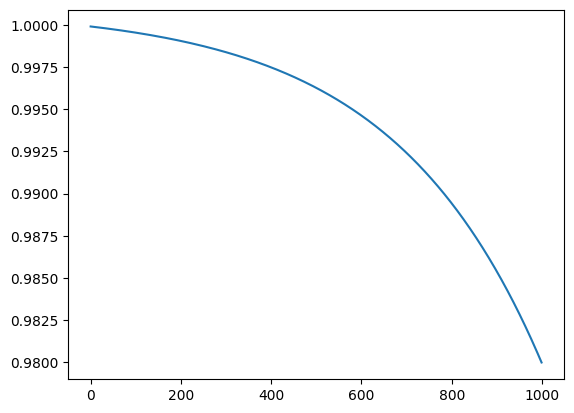

In [ ]:
plt.plot(cbs[-2].alpha)

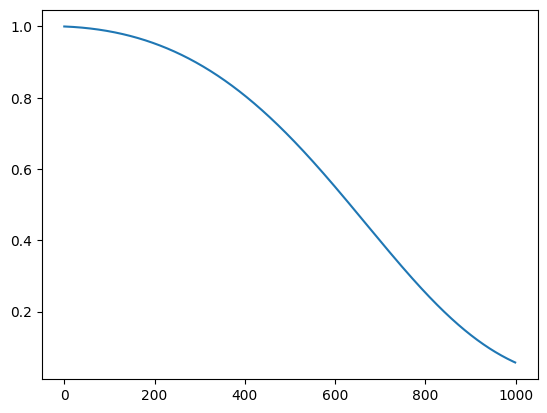

In [ ]:
plt.plot((cbs[-2].alpha_bar).sqrt())

In [ ]:
learner = AccLearnerV2(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))

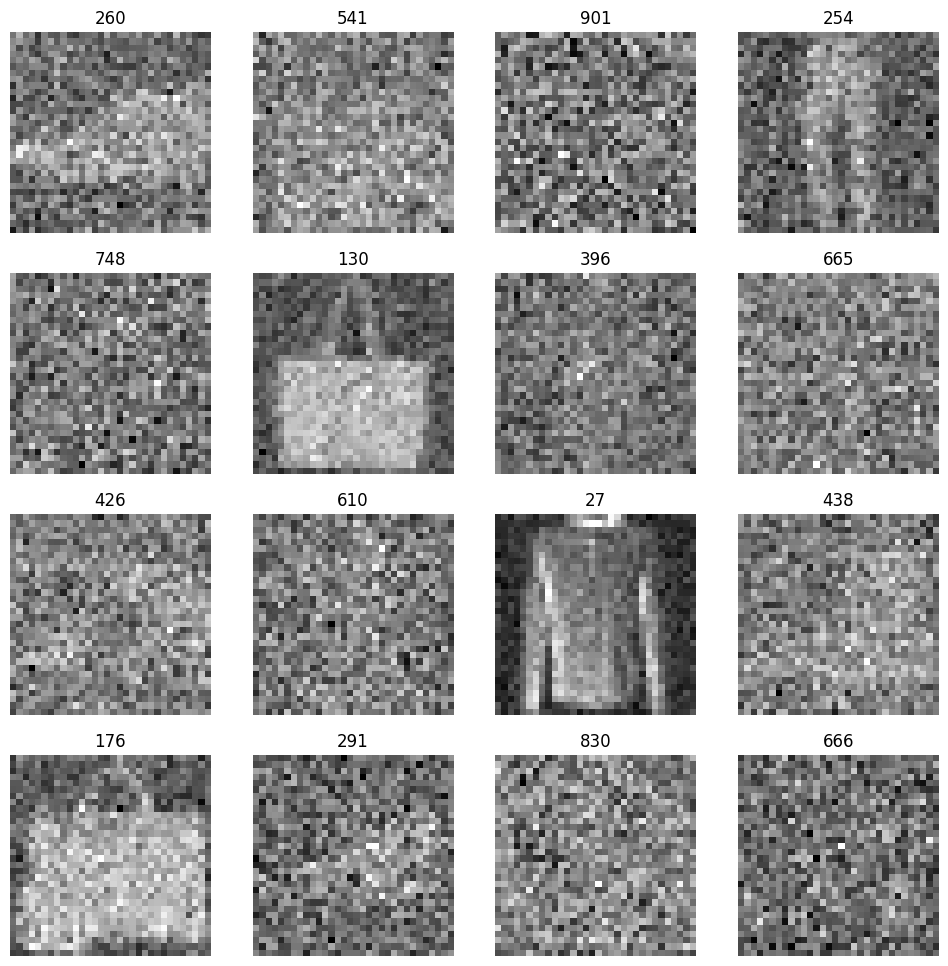

In [ ]:
# show_images(out[0][0][:16].cpu(), titles = out[0][1][:16].cpu())
out = learner.get_sample_batch()
show_images(out[0][0][:16].cpu(), titles = list(out[0][1][:16].cpu().numpy()))

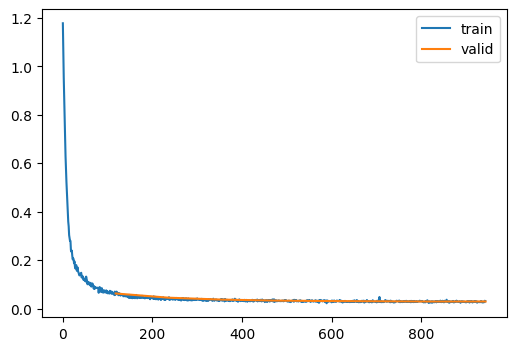

In [ ]:
learner.fit(epochs)

In [ ]:
torch.save(learner.model, mdl_path/'fashion_mnist_ddpm_exp_scheduler.pkl')

In [ ]:
out, coeffs = sample(learner.model, cbs[-2], out_shape=(128, 1, 32, 32))

1000it [01:28, 11.31it/s]


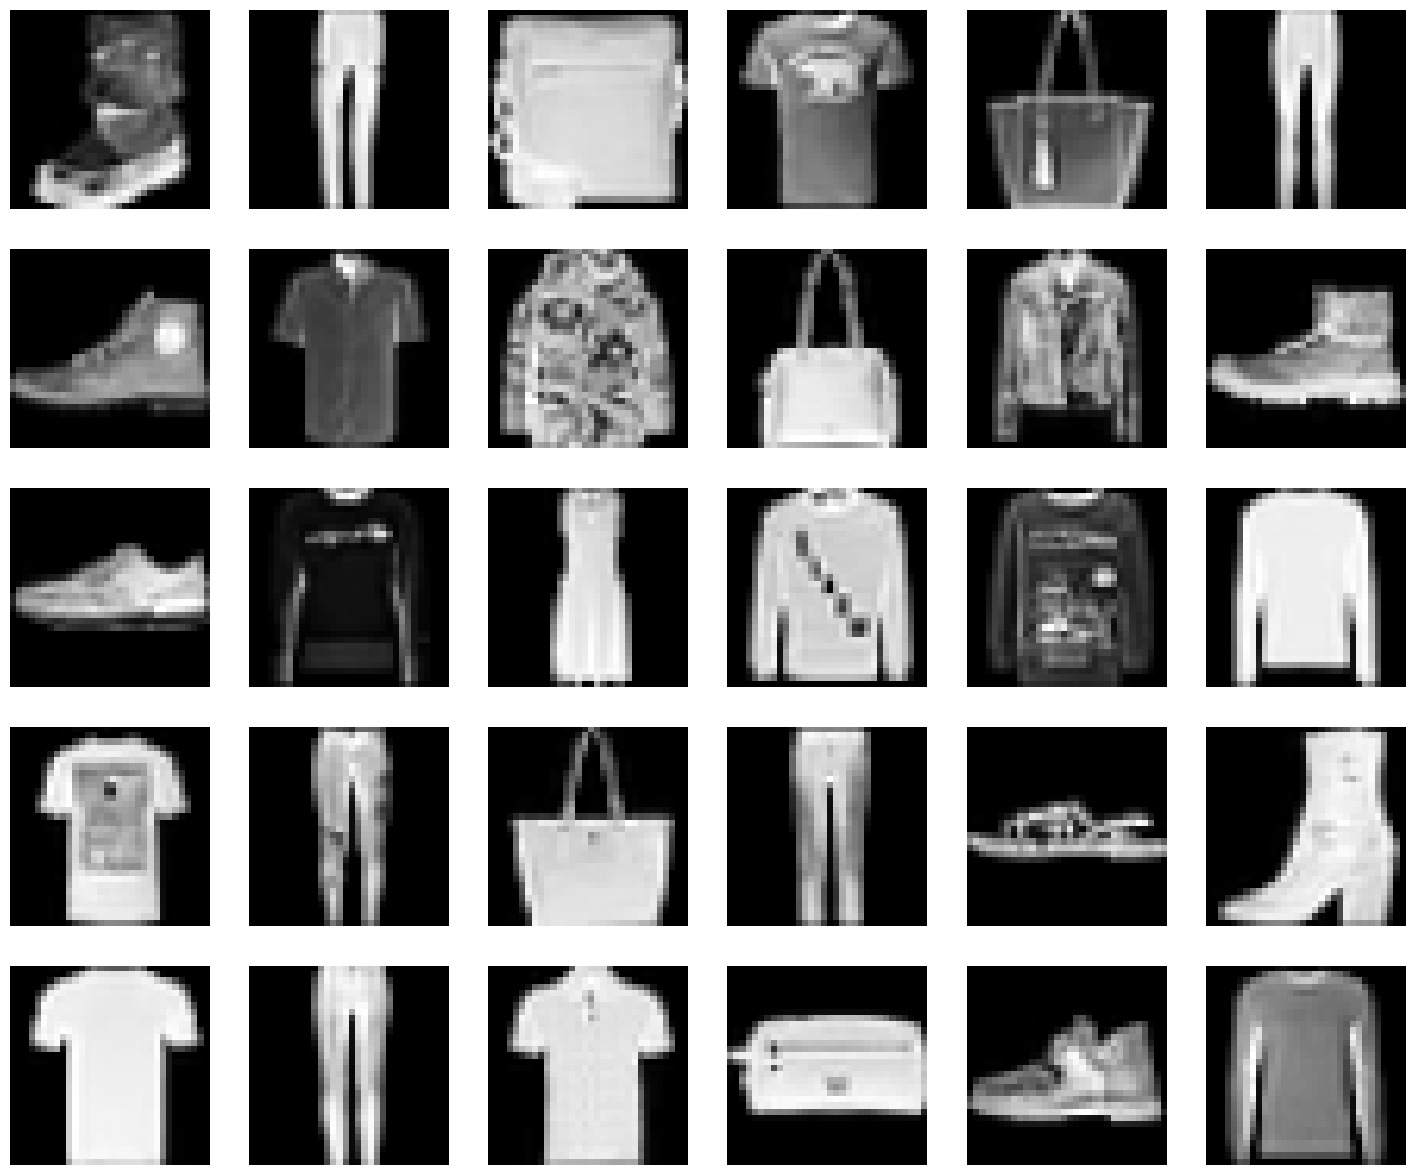

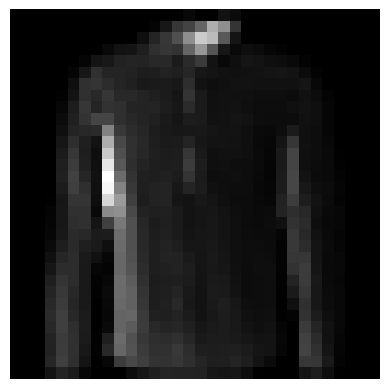

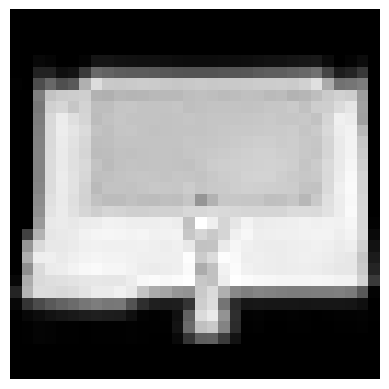

In [ ]:
x, y = next(iter(dls.train))
show_images(x[32:64])

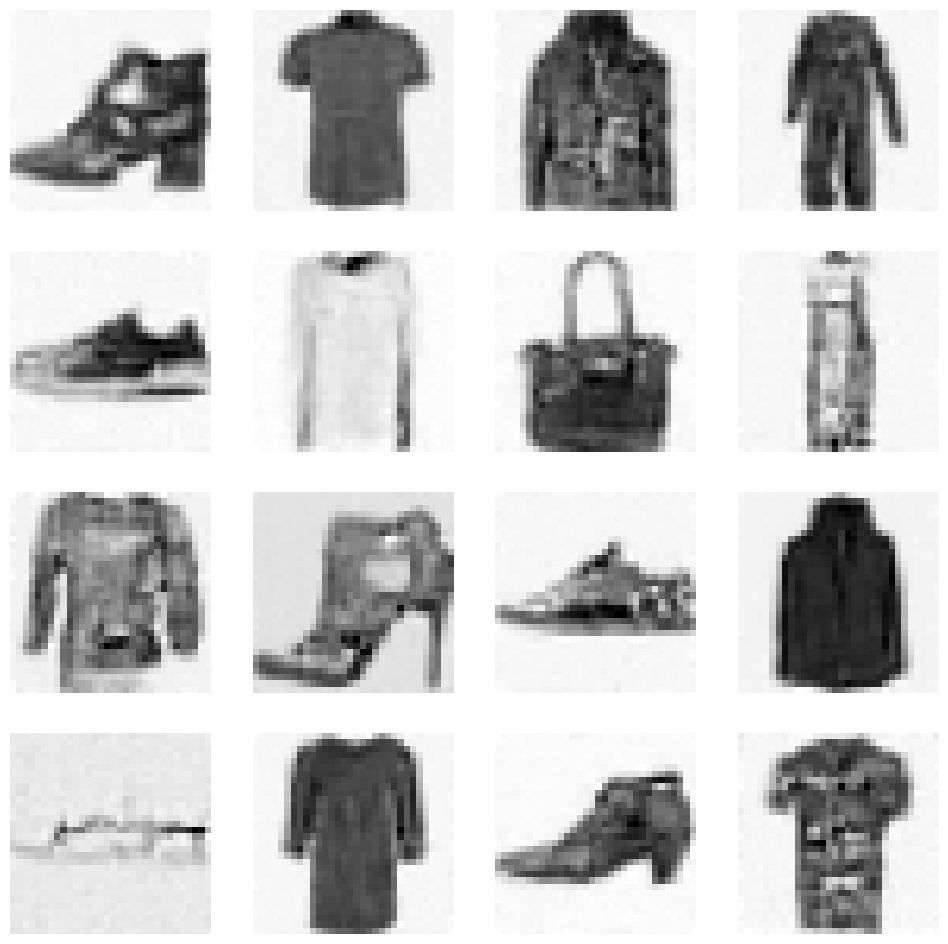

In [ ]:
show_images(-out[-1])

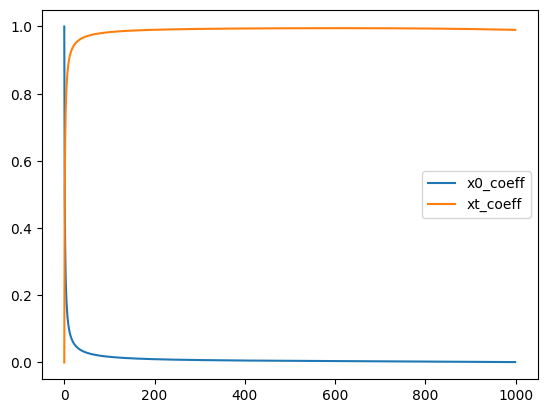

In [ ]:
plt.plot(list(reversed(coeffs[0])), label = 'x0_coeff')
plt.plot(list(reversed(coeffs[1])), label = 'xt_coeff')
plt.legend()

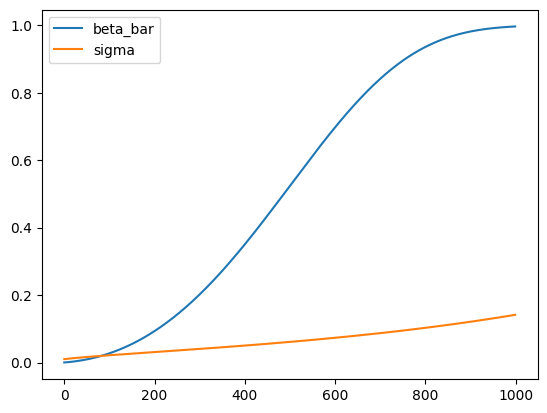

In [ ]:
plt.plot((1 - cbs[-2].alpha_bar.cpu()), label = 'beta_bar')
plt.plot((cbs[-2].sigma.cpu()), label = 'sigma')
plt.legend()

In [ ]:
@torch.no_grad()
def new_sample(model, cb = DDPMPrep(), out_shape = (16, 1, 32, 32)):
  preds, x0_coeffs, xt_coeffs = [], [], []
  n_steps, beta, alpha, alpha_bar, sigma = cb.n_steps, cb.beta.to(model.device), cb.alpha.to(model.device), cb.alpha_bar.to(model.device), cb.sigma.to(model.device)
  x_t = torch.randn(out_shape).to(model.device)
  for ts in tqdm(reversed(range(n_steps))):
    t_batch = torch.full((out_shape[0],), ts, device = model.device, dtype = torch.long)#torch.stack([torch.tensor([ts], device = model.device, dtype = torch.long)] * out_shape[0], dim = 0)
    noise_pred = model((x_t, t_batch))

    z = (torch.randn(x_t.shape) if ts > 0 else torch.zeros(x_t.shape)).to(model.device)
    alpha_bar_t_1 = alpha_bar[ts - 1] if ts > 0 else torch.tensor(1.)
    beta_bar_t = 1 - alpha_bar[ts]
    beta_bar_t_1 = 1 - alpha_bar_t_1
    alpha_bar_t = alpha_bar[ts]

    x0_hat = ((x_t - beta_bar_t.sqrt()*noise_pred)/(alpha_bar_t.sqrt())).clamp(-1, 1)
    # ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
    # x0_coeff = alpha_bar_t_1.sqrt() * (1 - alpha[ts])/beta_bar_t
    # xt_coeff = alpha[ts].sqrt()*beta_bar_t_1/beta_bar_t

    # x_t = x0_hat*x0_coeff + xt_coeff*x_t + sigma[ts]*z
    x_t = x0_hat*alpha_bar_t_1.sqrt() + beta_bar_t_1.sqrt()*z

    preds.append(x_t.cpu())
    # x0_coeffs.append(x0_coeff.cpu())
    # xt_coeffs.append(xt_coeff.cpu())

  return preds

In [ ]:
out = new_sample(learner.model, cbs[-2], out_shape=(32, 1, 32, 32))

1000it [00:33, 30.02it/s]


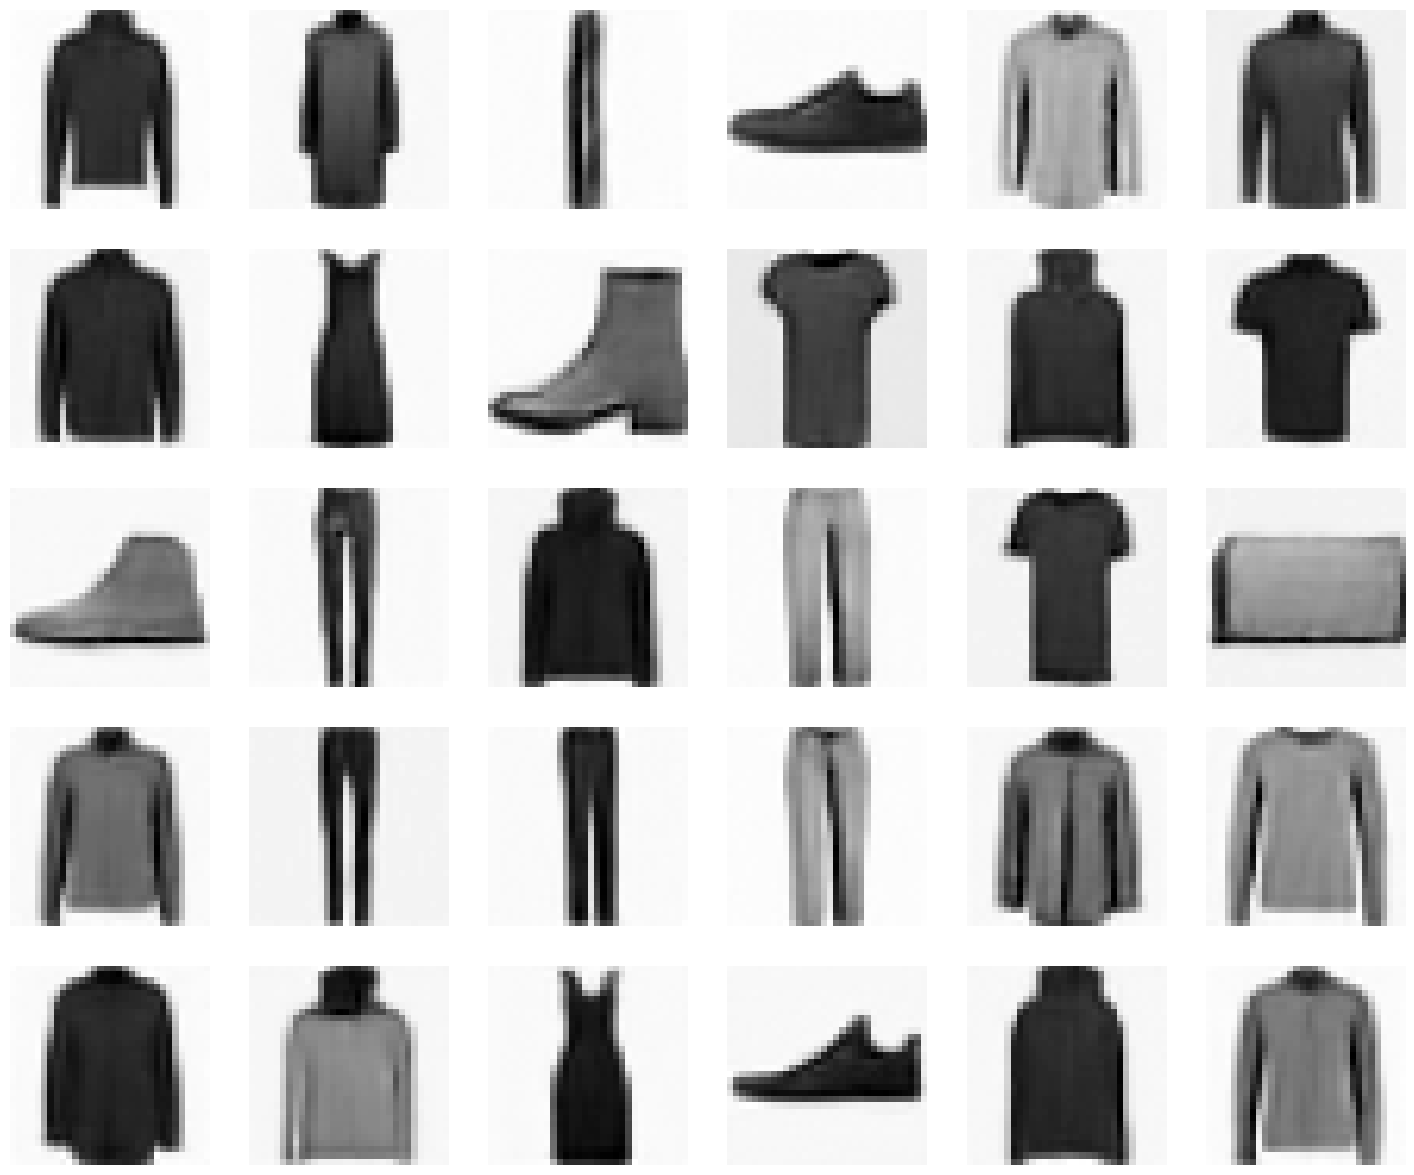

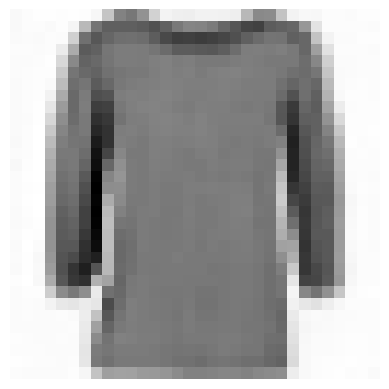

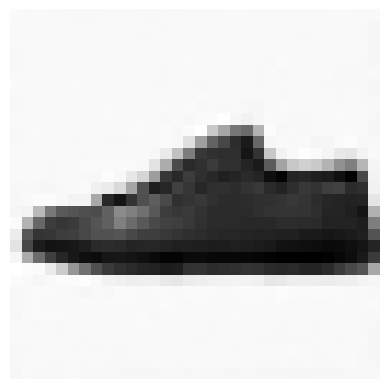

In [ ]:
show_images(-out[-1])

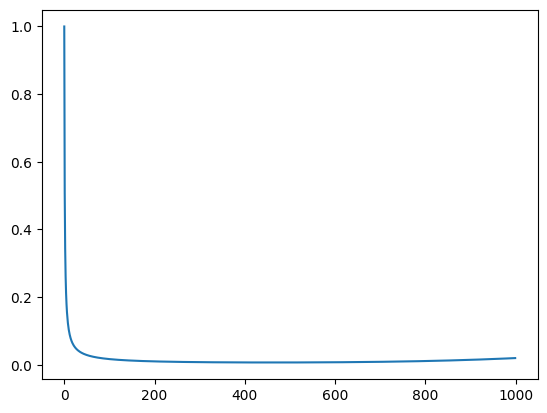

In [ ]:
cb = cbs[-2]
frac = (cb.beta.cpu()/(1. - cb.alpha_bar.cpu()))
plt.plot(frac)

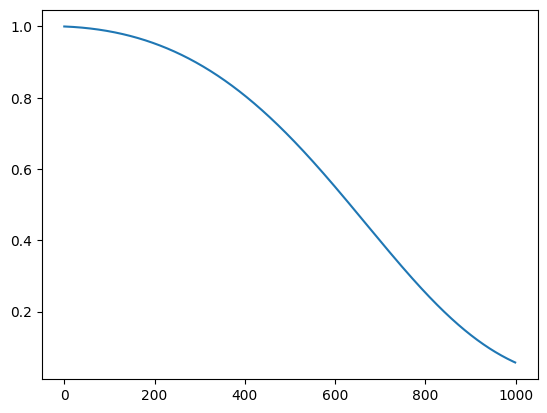

In [ ]:
plt.plot(cb.alpha_bar.sqrt().cpu())

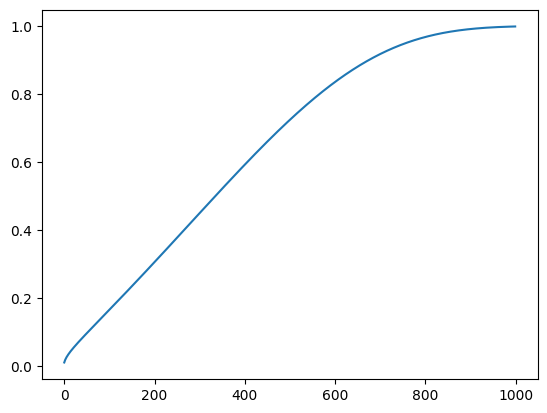

In [ ]:
plt.plot((1 - cb.alpha_bar).sqrt().cpu())

In [ ]:
x, y = next(iter(dls.train))


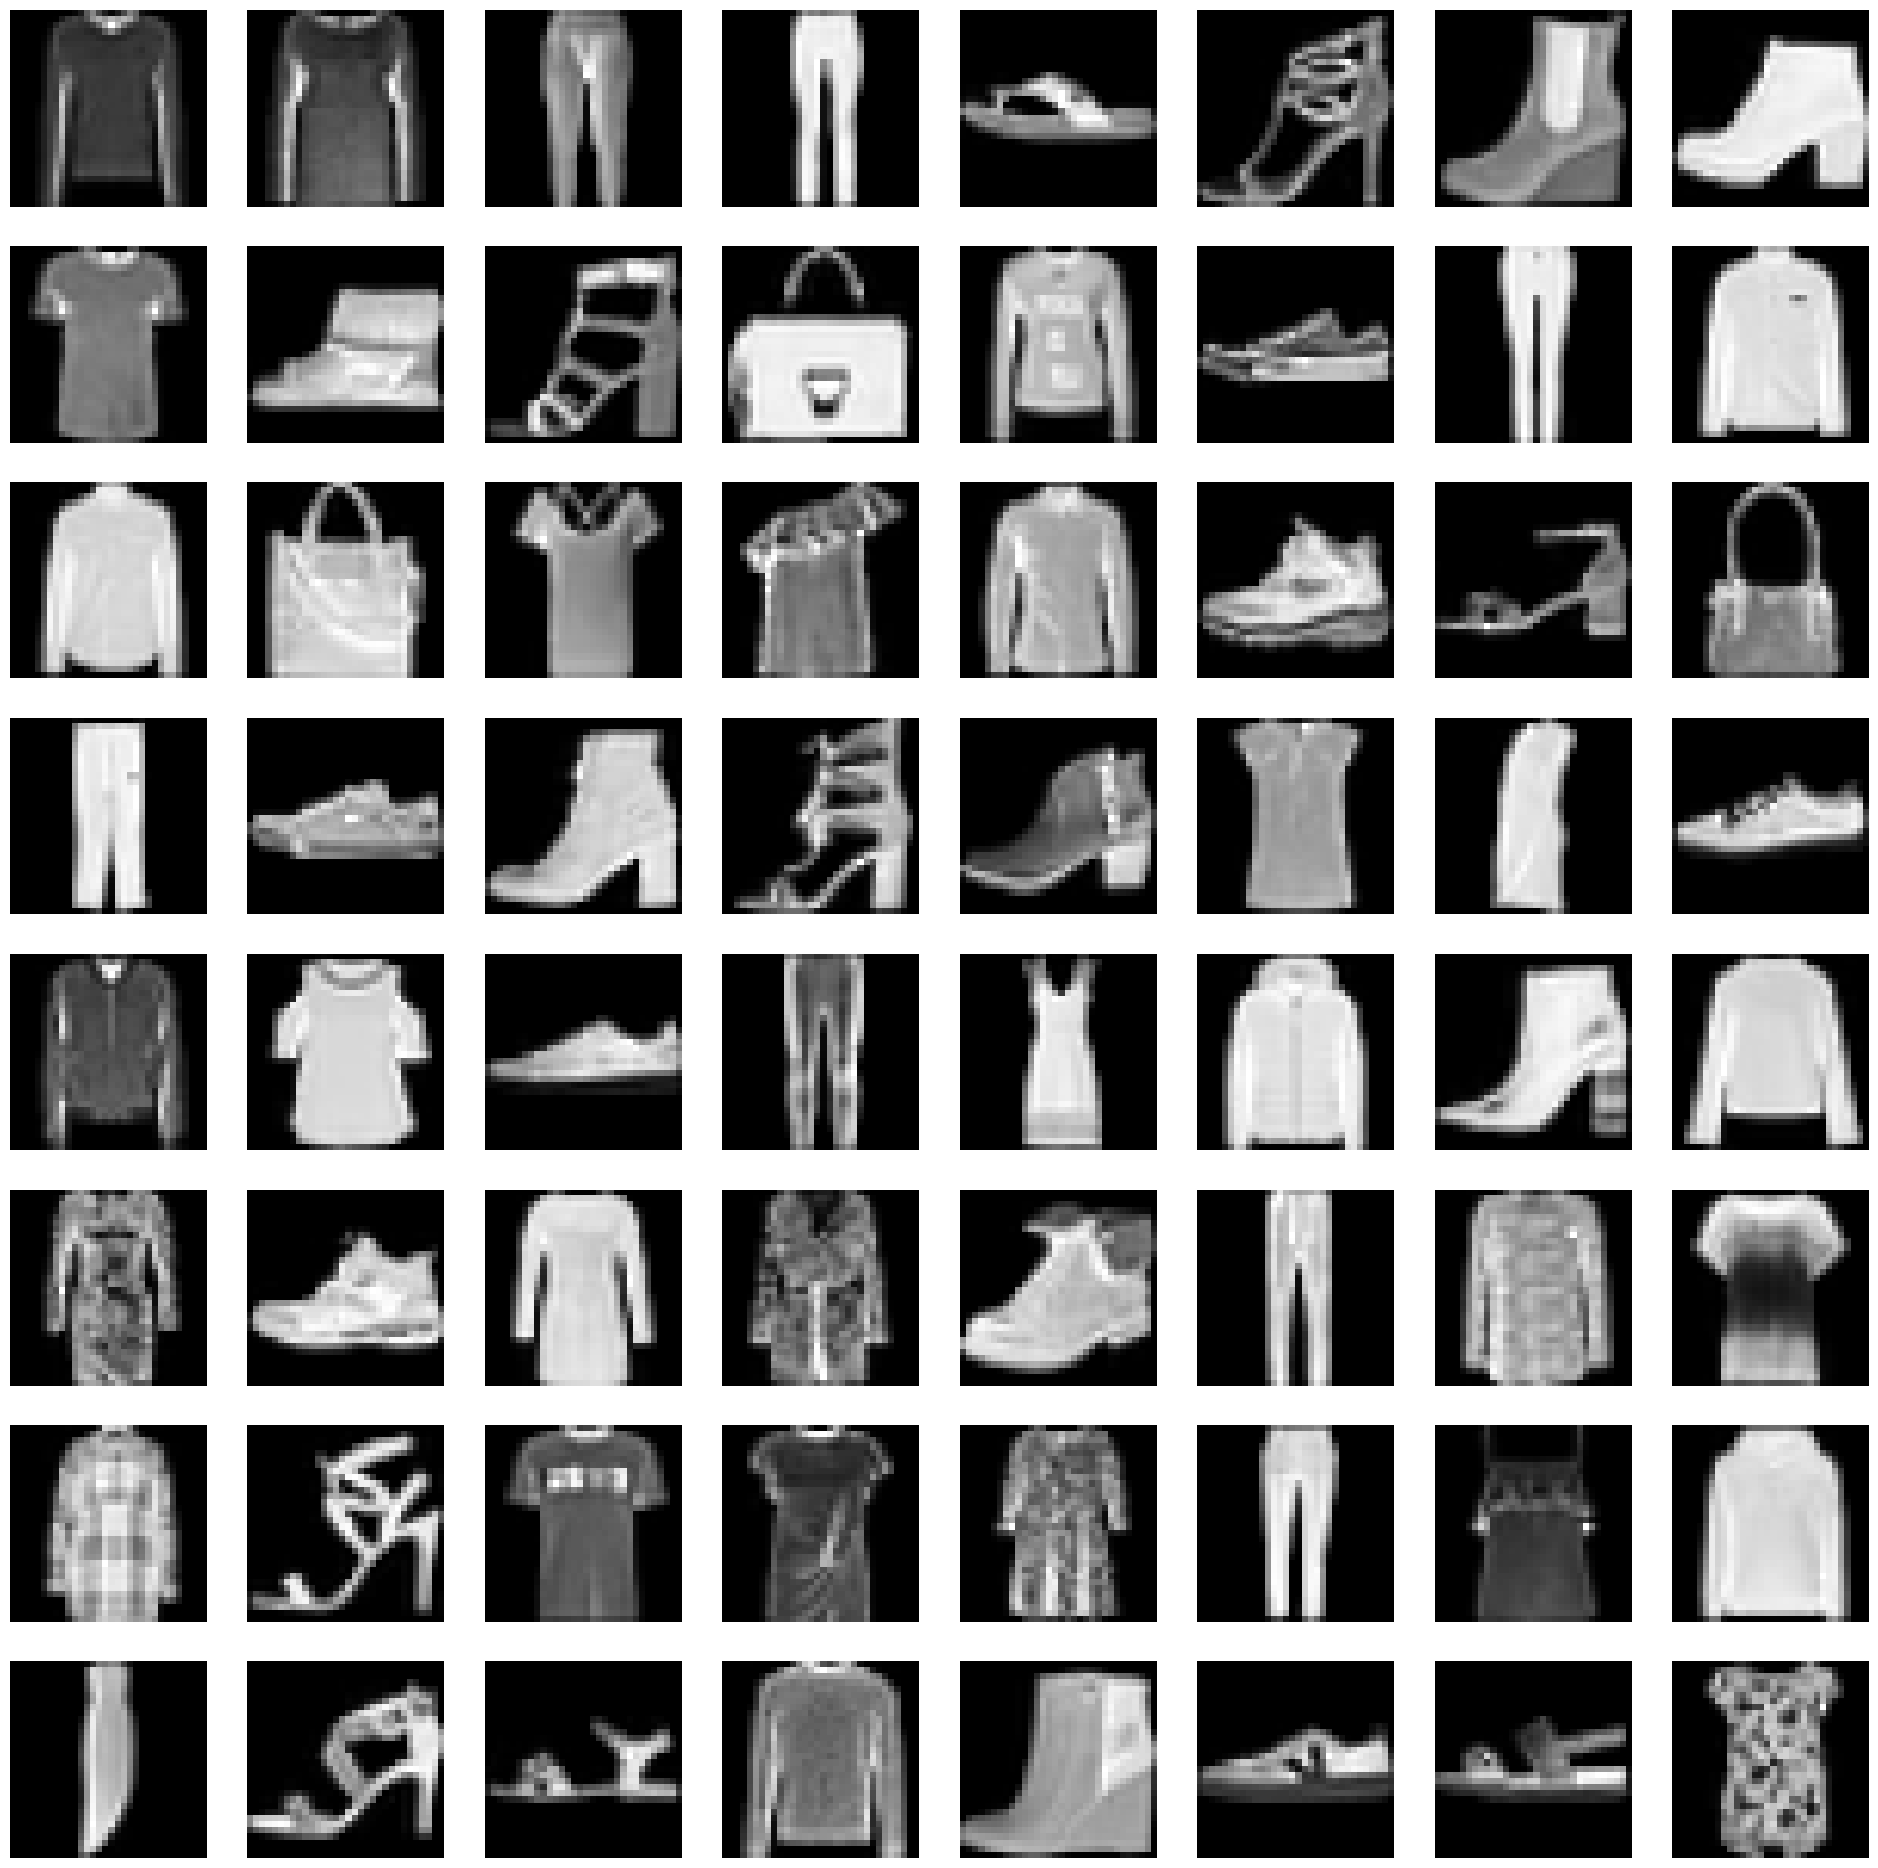

In [ ]:
show_images(x[:64].cpu())

In [ ]:
@torch.no_grad()
def sample_m(model, cb = DDPMPrep(), out_shape = (16, 1, 32, 32)):
  preds, x0_coeffs, xt_coeffs, means, stds = [], [], [], [], []
  n_steps, beta, alpha, alpha_bar, sigma = cb.n_steps, cb.beta.to(model.device), cb.alpha.to(model.device), cb.alpha_bar.to(model.device), cb.sigma.to(model.device)
  x_t = torch.randn(out_shape).to(model.device)
  for ts in tqdm(reversed(range(n_steps))):
    t_batch = torch.full((out_shape[0],), ts, device = model.device, dtype = torch.long)#torch.stack([torch.tensor([ts], device = model.device, dtype = torch.long)] * out_shape[0], dim = 0)
    noise_pred = model((x_t, t_batch))

    z = (torch.randn(x_t.shape) if ts > 0 else torch.zeros(x_t.shape)).to(model.device)
    alpha_bar_t_1 = alpha_bar[ts - 1] if ts > 0 else torch.tensor(1.)
    beta_bar_t = 1 - alpha_bar[ts]
    beta_bar_t_1 = 1 - alpha_bar_t_1
    alpha_bar_t = alpha_bar[ts]

    x0_hat = ((x_t - beta_bar_t.sqrt()*noise_pred)/(alpha_bar_t.sqrt())).clamp(-1, 1)
    # ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
    x0_coeff = alpha_bar_t_1.sqrt() * (1 - alpha[ts])/beta_bar_t
    xt_coeff = alpha[ts].sqrt()*beta_bar_t_1/beta_bar_t

    x_t = x0_hat*x0_coeff + xt_coeff*x_t + sigma[ts]*z

    preds.append(x_t.cpu())
    x0_coeffs.append(x0_coeff.cpu())
    xt_coeffs.append(xt_coeff.cpu())
    means.append(x_t.mean().cpu())
    stds.append(x_t.std().cpu())

  return preds, (x0_coeffs, xt_coeffs), (means, stds)

In [ ]:
out, _, stats = sample_m(learner.model, cbs[-2])

1000it [00:29, 33.72it/s]


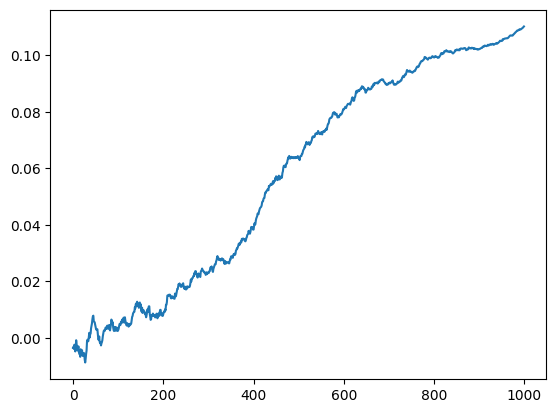

In [ ]:
plt.plot(stats[0])

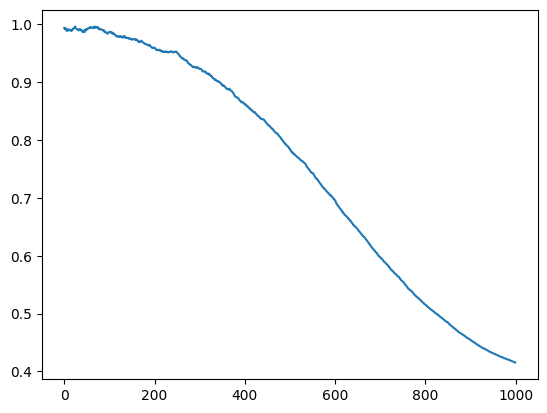

In [ ]:
plt.plot(stats[1])

In [ ]:
x.mean(), x.std()

(tensor(0.2841, device='cuda:0'), tensor(0.3362, device='cuda:0'))

# Reducing the timesteps from 1000 to 200

In [ ]:
model = UnetModel(in_channels=1, out_channels = 1, block_out_channels = (32, 64, 128, 128))
lr_max, epochs = 3e-03, 10
dls = DataLoaders.from_dd(tds, 512, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
          MetricsCB(),
          ProgressCB(plot = True),
          DDPMPrepV2(n_steps = 200, beta = get_exp(n_steps = 200, x_start = -2, x_end = 1), name = 'exp_-2_to_1'),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train)))
      ]

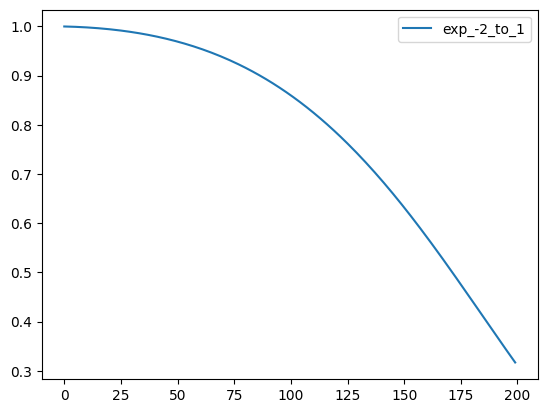

In [ ]:
plot_attrs([cbs[-2]], 'alpha_bar')

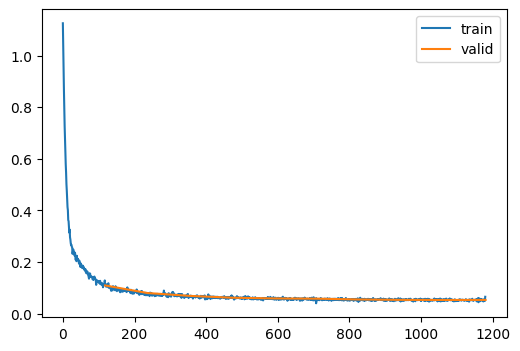

In [ ]:
learner = AccLearnerV2(model, dls, loss_func = nn.MSELoss(), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.Adam, eps = 1e-05))
learner.fit(epochs)

In [ ]:
out_2, _, stats = sample_m(learner.model, cb = cbs[-2])

200it [00:11, 17.39it/s]


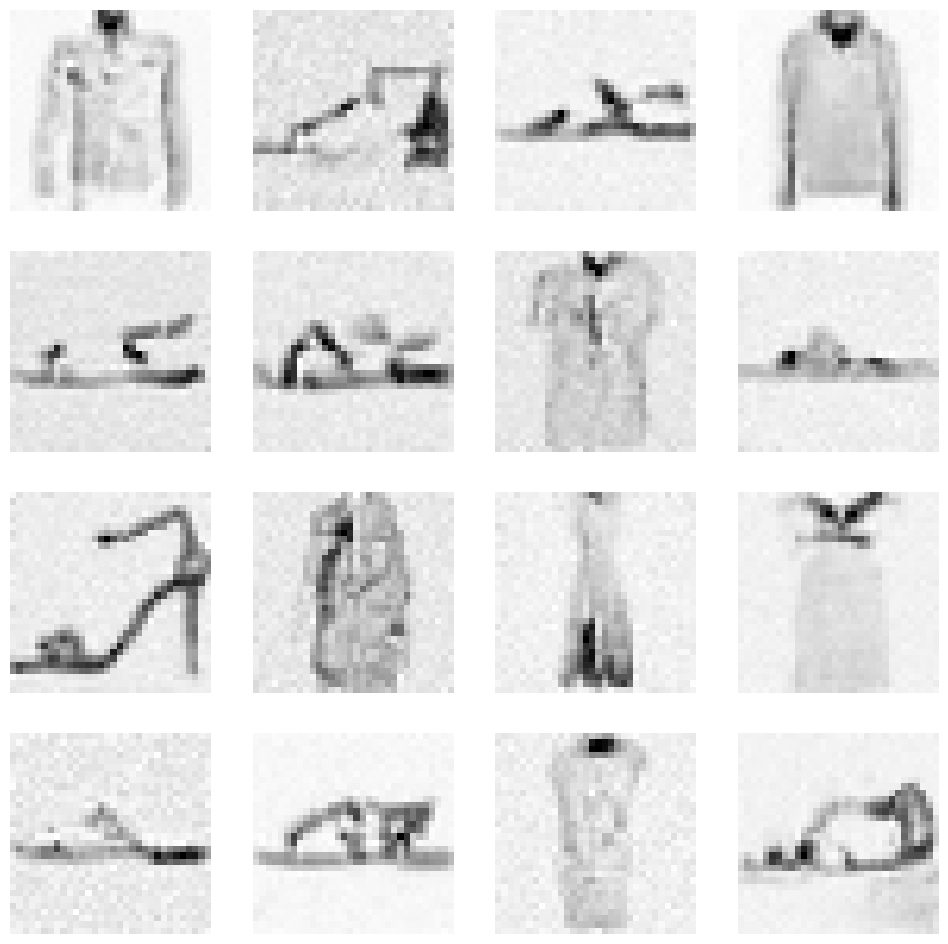

In [ ]:
show_images(-out_2[-1])